In [1]:
%reload_ext autoreload
%autoreload 2

import requests
import matplotlib.pyplot as plt
import json
import csv
import os
import pandas as pd
import numpy as np

import fundamentalanalysis as fa
import yfinance as yf
from yahoofinancials import YahooFinancials
from fmp_python.fmp import FMP
from fmp_api_python.fmp import FMPClient

#from verstack import PandasOptimizer
#from verstack import NaNImputer
from pypots.imputation import SAITS
from xgbimputer import XGBImputer

import math
from scipy.stats import norm

import nest_asyncio
from aiohttp import ClientSession
import aiofiles
import aiohttp
import asyncio

from tqdm import tqdm

from scipy import signal
from skimage.restoration import (denoise_wavelet, estimate_sigma)


# VIX Data

In [3]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

vix=pd.read_csv('raw_data/VIX_History.csv')

vix

,DATE,OPEN,HIGH,LOW,CLOSE
0,01/02/1990,17.24,17.24,17.24,17.24
1,01/03/1990,18.19,18.19,18.19,18.19
2,01/04/1990,19.22,19.22,19.22,19.22
3,01/05/1990,20.11,20.11,20.11,20.11
4,01/08/1990,20.26,20.26,20.26,20.26
...,...,...,...,...,...
8332,01/25/2023,19.56,20.90,18.99,19.08
8333,01/26/2023,19.05,19.48,18.67,18.73
8334,01/27/2023,18.90,19.00,17.97,18.51
8335,01/30/2023,19.76,20.25,19.54,19.94


# JGB Yield Curves

In [5]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

japan_curves=pd.read_csv('raw_data/Yield Curves/jgbcme_all.csv')


In [6]:
japan_curves

,Interest Rate,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,(Unit : %)
0,Date,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y,40Y
1,1974/9/24,10.327,9.362,8.83,8.515,8.348,8.29,8.24,8.121,8.127,-,-,-,-,-,-
2,1974/9/25,10.333,9.364,8.831,8.516,8.348,8.29,8.24,8.121,8.127,-,-,-,-,-,-
3,1974/9/26,10.34,9.366,8.832,8.516,8.348,8.29,8.24,8.122,8.128,-,-,-,-,-,-
4,1974/9/27,10.347,9.367,8.833,8.517,8.349,8.29,8.24,8.122,8.128,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12410,2023/1/25,-0.045,-0.01,0.004,0.083,0.189,0.257,0.317,0.424,0.415,0.457,1.001,1.299,1.464,1.535,1.69
12411,2023/1/26,-0.055,-0.009,0.006,0.083,0.189,0.252,0.311,0.429,0.432,0.483,1.021,1.313,1.47,1.526,1.671
12412,2023/1/27,-0.055,0.001,0.014,0.095,0.2,0.283,0.364,0.485,0.51,0.497,1.087,1.377,1.518,1.574,1.697
12413,2023/1/30,-0.055,-0.004,0.011,0.087,0.187,0.273,0.361,0.472,0.493,0.497,1.09,1.386,1.534,1.596,1.725


# Euro Zone Yield Curves

In [7]:
## Read large kaggle quarterly FS file

os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")
data = pd.read_csv('quarterly.csv')

data

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_49758/554400424.py:4: DtypeWarning: Columns (10,12,13,17,18,20,25,26,30,32,33,34,35,647,648,649,650,654,656,657,664,668,669,674,675,677,678,679) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('quarterly.csv')


,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1000,03/31/1966,1966,1,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
1,1000,06/30/1966,1966,2,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
2,1000,09/30/1966,1966,3,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
3,1000,12/31/1966,1966,4,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
4,1000,03/31/1967,1967,1,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829911,339965,10/31/2019,2019,3,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829912,339965,01/31/2020,2019,4,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829913,339965,04/30/2020,2020,1,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829914,339965,07/31/2020,2020,2,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020


In [3]:
os.chdir("/Users/veesheenyuen/Desktop/")

opt = PandasOptimizer()

euro_curves=pd.read_csv('DataScience/Data/euro_yield_curves.csv')

euro_curves = opt.optimize_memory_usage(euro_curves)

NameError: name 'PandasOptimizer' is not defined

In [20]:
euro_curves

,KEY,FREQ,REF_AREA,CURRENCY,PROVIDER_FM,INSTRUMENT_FM,PROVIDER_FM_ID,DATA_TYPE_FM,TIME_PERIOD,OBS_VALUE,...,UNIT_INDEX_BASE,COMPILATION,COVERAGE,DECIMALS,SOURCE_AGENCY,SOURCE_PUB,TITLE,TITLE_COMPL,UNIT,UNIT_MULT
0,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-06,5.441406,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
1,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-07,5.441406,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
2,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-08,5.425781,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
3,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-09,5.394531,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
4,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-10,5.363281,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5061955,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-23,0.624023,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061956,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-27,0.637207,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061957,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-28,0.636230,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061958,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-29,0.618652,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0


# FINANCIAL MODELING PREP

In [8]:
api_key='22ee76be0cd226eba06f81a9d2783cb0'

In [3]:
companies=["AAPL"]

# Balance sheet

for company in companies:
        
    balance_sheet=requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{company}?period=quarter&limit=400&apikey={api_key}')
    
    try:
        balance_sheet.json()[0]['date']
        print("data")
        
    except IndexError:
        print("no data")

        
         
balance_sheet=balance_sheet.json()

balance_sheet[0]['date']

data


'2022-12-31'

In [4]:
total_current_assets=balance_sheet[0]['totalCurrentAssets']

In [5]:
print(balance_sheet[0].keys())

dict_keys(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate', 'acceptedDate', 'calendarYear', 'period', 'cashAndCashEquivalents', 'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables', 'inventory', 'otherCurrentAssets', 'totalCurrentAssets', 'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets', 'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets', 'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets', 'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables', 'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities', 'longTermDebt', 'deferredRevenueNonCurrent', 'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities', 'totalNonCurrentLiabilities', 'otherLiabilities', 'capitalLeaseObligations', 'totalLiabilities', 'preferredStock', 'commonStock', 'retainedEarnings', 'accumulatedOtherComprehensiveIncomeLoss', 'othertotalStockholdersEquity', 'totalStockholdersEquity', 'totalEquity', 'totalLiabilitiesAndS

In [6]:
balance_sheet[0]['date']

'2022-12-31'

In [7]:
balance_sheet_columns=pd.DataFrame(balance_sheet).columns

In [8]:
balance_sheet_columns

Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'cashAndCashEquivalents',
       'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
       'inventory', 'otherCurrentAssets', 'totalCurrentAssets',
       'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
       'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
       'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
       'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
       'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
       'longTermDebt', 'deferredRevenueNonCurrent',
       'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
       'totalNonCurrentLiabilities', 'otherLiabilities',
       'capitalLeaseObligations', 'totalLiabilities', 'preferredStock',
       'commonStock', 'retainedEarnings',
       'accumulatedOtherComprehensiveIncomeLoss',
 

In [13]:
# Income statement

for company in companies:
        
    income_statement=requests.get(f'https://financialmodelingprep.com/api/v3/income-statement/{company}?period=quarter&limit=400&apikey={api_key}')
    
    try:
        income_statement.json()[0]['date']
        print("data")
        
    except IndexError:
        print("no data")          
    
    
income_statement=income_statement.json()

income_statement=pd.DataFrame(income_statement)

data


In [14]:
income_statement_columns=income_statement.columns

income_statement_columns

Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome',
       'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut',
       'weightedAverageShsOutDil', 'link', 'finalLink'],
      dtype='object')

In [11]:
# Cashflow

for company in companies:
        
    CashFlow=requests.get(f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{company}?period=quarter&limit=400&apikey={api_key}')
    
    try:
        CashFlow.json()[0]['date']
        print("data")
        
    except IndexError:
        print("no data")

        
CashFlow=CashFlow.json()

CashFlow
        
        

data


[{'date': '2022-12-31',
  'symbol': 'AAPL',
  'reportedCurrency': 'USD',
  'cik': '0000320193',
  'fillingDate': '2023-02-03',
  'acceptedDate': '2023-02-02 18:01:30',
  'calendarYear': '2023',
  'period': 'Q1',
  'netIncome': 29998000000,
  'depreciationAndAmortization': 2916000000,
  'deferredIncomeTax': 0,
  'stockBasedCompensation': 2905000000,
  'changeInWorkingCapital': -1497000000,
  'accountsReceivables': 4275000000,
  'inventory': -1807000000,
  'accountsPayables': -6075000000,
  'otherWorkingCapital': 131000000,
  'otherNonCashItems': -317000000,
  'netCashProvidedByOperatingActivities': 34005000000,
  'investmentsInPropertyPlantAndEquipment': -3787000000,
  'acquisitionsNet': 0,
  'purchasesOfInvestments': -5153000000,
  'salesMaturitiesOfInvestments': 7636000000,
  'otherInvestingActivites': -141000000,
  'netCashUsedForInvestingActivites': -1445000000,
  'debtRepayment': -9615000000,
  'commonStockIssued': 0,
  'commonStockRepurchased': -19475000000,
  'dividendsPaid': -37

In [12]:
print(CashFlow[0].keys())

dict_keys(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate', 'acceptedDate', 'calendarYear', 'period', 'netIncome', 'depreciationAndAmortization', 'deferredIncomeTax', 'stockBasedCompensation', 'changeInWorkingCapital', 'accountsReceivables', 'inventory', 'accountsPayables', 'otherWorkingCapital', 'otherNonCashItems', 'netCashProvidedByOperatingActivities', 'investmentsInPropertyPlantAndEquipment', 'acquisitionsNet', 'purchasesOfInvestments', 'salesMaturitiesOfInvestments', 'otherInvestingActivites', 'netCashUsedForInvestingActivites', 'debtRepayment', 'commonStockIssued', 'commonStockRepurchased', 'dividendsPaid', 'otherFinancingActivites', 'netCashUsedProvidedByFinancingActivities', 'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod', 'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure', 'freeCashFlow', 'link', 'finalLink'])


In [13]:
cashflow_columns=pd.DataFrame(CashFlow).columns

cashflow_columns

Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'netIncome',
       'depreciationAndAmortization', 'deferredIncomeTax',
       'stockBasedCompensation', 'changeInWorkingCapital',
       'accountsReceivables', 'inventory', 'accountsPayables',
       'otherWorkingCapital', 'otherNonCashItems',
       'netCashProvidedByOperatingActivities',
       'investmentsInPropertyPlantAndEquipment', 'acquisitionsNet',
       'purchasesOfInvestments', 'salesMaturitiesOfInvestments',
       'otherInvestingActivites', 'netCashUsedForInvestingActivites',
       'debtRepayment', 'commonStockIssued', 'commonStockRepurchased',
       'dividendsPaid', 'otherFinancingActivites',
       'netCashUsedProvidedByFinancingActivities',
       'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod',
       'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure',
       'freeCashFlow', 'link', 'finalLink'],
      dtype='obje

In [14]:
# Ratios

for company in companies:
        
    ratios=requests.get(f'https://financialmodelingprep.com/api/v3/ratios/{company}?period=quarter&limit=400&apikey={api_key}')
    
    try:
        ratios.json()[0]['date']
        print("data")
        
    except IndexError:
        print("no data")

        
Ratios=ratios.json()

Ratios
        


data


[{'symbol': 'AAPL',
  'date': '2022-12-31',
  'period': 'Q1',
  'currentRatio': 0.9380199000626429,
  'quickRatio': 0.7687236863190712,
  'cashRatio': 0.1495782526987457,
  'daysOfSalesOutstanding': 168.80089454905507,
  'daysOfInventoryOutstanding': 9.185597557690581,
  'operatingCycle': 50.80773593964936,
  'daysOfPayablesOutstanding': 78.00754242614708,
  'cashConversionCycle': -27.19980648649772,
  'grossProfitMargin': 0.42962254809908323,
  'operatingProfitMargin': 0.30742441572630896,
  'pretaxProfitMargin': 0.3040698567697219,
  'netProfitMargin': 0.2560561312460522,
  'effectiveTaxRate': 0.15790360160570419,
  'returnOnAssets': 0.08651264466599567,
  'returnOnEquity': 0.5288134398082042,
  'returnOnCapitalEmployed': 0.1719460902029495,
  'netIncomePerEBT': 0.8420963983942958,
  'ebtPerEbit': 0.9890881830297645,
  'ebitPerRevenue': 0.30742441572630896,
  'debtRatio': 0.8364023336899814,
  'debtEquityRatio': 5.1125566308812385,
  'longTermDebtToCapitalization': 0.6371886872097932

In [15]:
print(Ratios[0].keys())

dict_keys(['symbol', 'date', 'period', 'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding', 'daysOfInventoryOutstanding', 'operatingCycle', 'daysOfPayablesOutstanding', 'cashConversionCycle', 'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin', 'effectiveTaxRate', 'returnOnAssets', 'returnOnEquity', 'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit', 'ebitPerRevenue', 'debtRatio', 'debtEquityRatio', 'longTermDebtToCapitalization', 'totalDebtToCapitalization', 'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier', 'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover', 'fixedAssetTurnover', 'assetTurnover', 'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio', 'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio', 'cashFlowCoverageRatios', 'shortTermCoverageRatios', 'capitalExpenditureCoverageRatio', 'dividendPaidAndCapexCoverageRatio', 'dividendPayoutRatio', 'pri

In [16]:
ratios_columns=pd.DataFrame(Ratios).columns

ratios_columns

Index(['symbol', 'date', 'period', 'currentRatio', 'quickRatio', 'cashRatio',
       'daysOfSalesOutstanding', 'daysOfInventoryOutstanding',
       'operatingCycle', 'daysOfPayablesOutstanding', 'cashConversionCycle',
       'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin',
       'netProfitMargin', 'effectiveTaxRate', 'returnOnAssets',
       'returnOnEquity', 'returnOnCapitalEmployed', 'netIncomePerEBT',
       'ebtPerEbit', 'ebitPerRevenue', 'debtRatio', 'debtEquityRatio',
       'longTermDebtToCapitalization', 'totalDebtToCapitalization',
       'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier',
       'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover',
       'fixedAssetTurnover', 'assetTurnover', 'operatingCashFlowPerShare',
       'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio',
       'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio',
       'cashFlowCoverageRatios', 'shortTermCoverageRatios',
       'capi

In [17]:
# Key Metrics

for company in companies:
        
    key_metrics=requests.get(f'https://financialmodelingprep.com/api/v3/key-metrics/{company}?period=quarter&limit=400&apikey={api_key}')
    
    try:
        key_metrics.json()[0]['date']
        print("data")
        
    except IndexError:
        print("no data")

        
Key_Metrics=key_metrics.json()

df_Metrics=pd.DataFrame(Key_Metrics)
        

data


In [18]:
key_metrics_columns=df_Metrics.columns

key_metrics_columns

Index(['symbol', 'date', 'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRatio',
       'salesGeneralAndAdministrativeToRevenue',
       'researchAndDdevelopementToRevenue', 'intangiblesToTotalAssets',
       'capexToOperatingCashFlow', 'capexToRevenue', 'capexToDepreciation',
       'stockBasedCompensationToRevenue', 'grahamNumber', 'roic',
       'returnOnTangibleAssets', 'grahamNetNet', 'wo

#  Kaggle CDS Data

In [7]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

CDS=pd.read_csv('raw_data/cds.csv')

In [8]:
CDS['Date']= pd.to_datetime(CDS['Date'])

CDS.set_index('Date', inplace=True)

CDS

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-01,A,Agilent Technologies Inc,14.8500,25.0500,39.0550,73.7150,86.3000,111.3050,125.9050,144.3000,158.6000,168.1950
2015-01-02,A,Agilent Technologies Inc,14.8550,25.1500,39.1600,73.6000,86.4000,111.5100,126.1000,144.3750,158.7750,168.3750
2015-01-05,A,Agilent Technologies Inc,13.4550,24.9600,39.3100,70.2000,88.2600,111.9700,125.0600,143.1650,157.3850,166.8250
2015-01-06,A,Agilent Technologies Inc,15.5350,24.8800,39.3000,72.6800,91.1000,116.6100,130.8900,150.3650,165.6550,175.8850
2015-01-07,A,Agilent Technologies Inc,15.2150,25.5000,40.2700,73.8800,92.5000,117.7800,131.9400,151.1450,166.2150,176.2950
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-06,ZIGGO,Ziggo,43.1264,87.0118,129.5117,172.7865,214.8831,266.7008,302.0419,327.0323,345.8258,360.3988
2021-09-07,ZIGGO,Ziggo,43.1224,86.7150,132.9410,176.4412,222.3668,277.1234,313.9639,339.7347,358.9416,373.7222
2021-09-08,ZIGGO,Ziggo,42.3178,86.5418,131.5519,178.4565,223.4681,277.5741,314.0263,339.5492,358.5867,373.2473


In [9]:
CDS.isnull().sum() 

Ticker     0
Company    0
PX1        0
PX2        0
PX3        0
PX4        0
PX5        0
PX6        0
PX7        0
PX8        0
PX9        0
PX10       0
dtype: int64

In [10]:
 CDS_test=CDS[CDS['Ticker']=='AAPL']

In [11]:
tickers_list =  CDS["Ticker"].unique().tolist()

name_list= CDS["Company"].unique().tolist()

In [12]:
column_values = CDS[['Ticker', 'Company']].values

CV=pd.DataFrame(column_values)

CV

,0,1
0,A,Agilent Technologies Inc
1,A,Agilent Technologies Inc
2,A,Agilent Technologies Inc
3,A,Agilent Technologies Inc
4,A,Agilent Technologies Inc
...,...,...
1061162,ZIGGO,Ziggo
1061163,ZIGGO,Ziggo
1061164,ZIGGO,Ziggo
1061165,ZIGGO,Ziggo


In [13]:
CV.duplicated()

0          False
1           True
2           True
3           True
4           True
           ...  
1061162     True
1061163     True
1061164     True
1061165     True
1061166     True
Length: 1061167, dtype: bool

In [14]:
# Isolate unique tickers

df_new = CV.drop_duplicates(0).sort_index()

df_new

,0,1
0,A,Agilent Technologies Inc
1747,AALLN,Anglo American PLC
3494,AAPL,Apple Inc
5241,ABBNVX,ABB Ltd
6988,ABBV,AbbVie Inc
...,...,...
1053495,WU,Western Union Co The
1055242,WY,Weyerhaeuser Co
1056989,XL,XLIT Ltd
1058736,XOM,Exxon Mobil Corp


## Process tickers from CDS file

In [17]:
df_new.rename(columns = {0:'Ticker', 1:'Company'}, inplace = True)

df_new.reset_index(drop=True)



,Ticker,Company
0,A,Agilent Technologies Inc
1,AALLN,Anglo American PLC
2,AAPL,Apple Inc
3,ABBNVX,ABB Ltd
4,ABBV,AbbVie Inc
...,...,...
656,WU,Western Union Co The
657,WY,Weyerhaeuser Co
658,XL,XLIT Ltd
659,XOM,Exxon Mobil Corp


In [250]:
df_new.iloc[68, 0]

'BAC'

## Get B/S

In [48]:
no_data_list = pd.DataFrame({'Ticker': [], 'Company': []})

got_data_list = pd.DataFrame({'Ticker': [], 'Company': []})

In [49]:
api_key='22ee76be0cd226eba06f81a9d2783cb0'

for i in range(len(df_new)):
        
    balance_sheet=requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{df_new.iloc[i, 0]}?period=quarter&limit=40&apikey={api_key}')
    
    try:
        if balance_sheet.json()[0]['date']:
            
            got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
     
    except IndexError:

        no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)



/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  no_data_list=no_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_1504/701500610.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  got_data_list=got_data_list.append({'Ticker':df_new.iloc[i, 0],'Company':df_new.iloc[i, 1]}, ignore_index=True)
/var/folders/q5/yf8

In [50]:
# write new files to csv

os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

#no_data_list.to_csv("no_data.csv")  

got_data_list.to_csv("got_data.csv")

In [32]:

no_data=pd.read_csv('no_data.csv')

no_data

,Unnamed: 0,Ticker,Company
0,0,AAL.L,Anglo American PLC
1,1,ABB,ABB Ltd
2,2,ABESM,Abertis Infraestructuras SA
3,3,ABI.BR,Anheuser Busch InBev SA NV
4,4,GOLD,Barrick Gold Corp
...,...,...,...
386,386,WKL.AS,Wolters Kluwer NV
387,387,WOORIB,Woori Bank Co Ltd
388,388,WPLAU,Woodside
389,389,WBC.AX,Westpac Banking Corp


In [52]:
no_data_list['Parsed']=no_data_list['Company'].str.split()

no_data_list['search_string']=np.nan

no_data_list['NYSE_response']=np.nan

no_data_list

,Unnamed: 0,Ticker,Company,Parsed,search_string,NYSE_response
0,0,AALLN,Anglo American PLC,"[Anglo, American, PLC]",NaN,NaN
1,1,ABBNVX,ABB Ltd,"[ABB, Ltd]",NaN,NaN
2,2,ABESM,Abertis Infraestructuras SA,"[Abertis, Infraestructuras, SA]",NaN,NaN
3,3,ABIBB,Anheuser Busch InBev SA NV,"[Anheuser, Busch, InBev, SA, NV]",NaN,NaN
4,4,ABXCN,Barrick Gold Corp,"[Barrick, Gold, Corp]",NaN,NaN
...,...,...,...,...,...,...
386,386,WKLNA,Wolters Kluwer NV,"[Wolters, Kluwer, NV]",NaN,NaN
387,387,WOORIB,Woori Bank Co Ltd,"[Woori, Bank, Co, Ltd]",NaN,NaN
388,388,WPLAU,Woodside,[Woodside],NaN,NaN
389,389,WSTP,Westpac Banking Corp,"[Westpac, Banking, Corp]",NaN,NaN


In [53]:
for i in range(0, 391):
    
    if len(no_data_list.iloc[i, 3])>2:

        no_data_list.iloc[i, 4]=((no_data_list.iloc[i, 3][0]+ ' ' + no_data_list.iloc[i, 3][1]))
    else:
        no_data_list.iloc[i, 4]=no_data_list.iloc[i, 3][0]
        

In [54]:
no_data_list.head(20)

,Unnamed: 0,Ticker,Company,Parsed,search_string,NYSE_response
0,0,AALLN,Anglo American PLC,"[Anglo, American, PLC]",Anglo American,NaN
1,1,ABBNVX,ABB Ltd,"[ABB, Ltd]",ABB,NaN
2,2,ABESM,Abertis Infraestructuras SA,"[Abertis, Infraestructuras, SA]",Abertis Infraestructuras,NaN
3,3,ABIBB,Anheuser Busch InBev SA NV,"[Anheuser, Busch, InBev, SA, NV]",Anheuser Busch,NaN
4,4,ABXCN,Barrick Gold Corp,"[Barrick, Gold, Corp]",Barrick Gold,NaN
5,5,ACAFP,Credit Agricole,"[Credit, Agricole]",Credit,NaN
6,6,ACEIM,ACEA SpA,"[ACEA, SpA]",ACEA,NaN
7,7,ACFP,Accor SA,"[Accor, SA]",Accor,NaN
8,8,ADENVX,Adecco Group AG,"[Adecco, Group, AG]",Adecco Group,NaN
9,9,ADLERR,ADLER Real Estate AG,"[ADLER, Real, Estate, AG]",ADLER Real,NaN


## Query company name based on keyword

In [22]:
os.chdir("/Users/veesheenyuen/Desktop/")

no_data_list=pd.read_csv('DataScience/Project/latest_sheet_no.csv')

no_data_list

,Unnamed: 0.1,Unnamed: 0,Ticker,Exchange,Company,Parsed,search_string,NYSE_response,EURONEXT,AMEX,NASDAQ
0,0.0,0.0,AAL.L,NaN,Anglo American PLC,"['Anglo', 'American', 'PLC']",Anglo American,NaN,NaN,0 [],0 []
1,1.0,1.0,ABB,NaN,ABB Ltd,"['ABB', 'Ltd']",ABB,ABB,"1 [{'symbol': 'MLSRP.PA', 'name': 'Speed Rabbi...",1 [],1 []
2,2.0,2.0,ABESM,NaN,Abertis Infraestructuras SA,"['Abertis', 'Infraestructuras', 'SA']",Abertis Infraestructuras,NaN,2 [],2 [],2 []
3,3.0,3.0,ABI.BR,NaN,Anheuser Busch InBev SA NV,"['Anheuser', 'Busch', 'InBev', 'SA', 'NV']",Anheuser Busch,NaN,3 [],3 [],3 []
4,4.0,4.0,GOLD,NaN,Barrick Gold Corp,"['Barrick', 'Gold', 'Corp']",Barrick Gold,GOLD,4 [],4 [],4 []
...,...,...,...,...,...,...,...,...,...,...,...
387,387.0,387.0,WOORIB,NaN,Woori Bank Co Ltd,"['Woori', 'Bank', 'Co', 'Ltd']",Woori Bank,NaN,387 [],387 [],387 []
388,388.0,388.0,WPLAU,NaN,Woodside,['Woodside'],Woodside,WDS?,388 [],388 [],388 []
389,389.0,389.0,WBC.AX,NaN,Westpac Banking Corp,"['Westpac', 'Banking', 'Corp']",Westpac Banking,WBK,389 [],389 [],389 []
390,390.0,390.0,ZIGGO,NaN,Ziggo,['Ziggo'],Ziggo,NaN,NaN,InÊ[Ê]:,NaN


In [23]:
no_data_list

,Unnamed: 0.1,Unnamed: 0,Ticker,Exchange,Company,Parsed,search_string,NYSE_response,EURONEXT,AMEX,NASDAQ
0,0.0,0.0,AAL.L,NaN,Anglo American PLC,"['Anglo', 'American', 'PLC']",Anglo American,NaN,NaN,0 [],0 []
1,1.0,1.0,ABB,NaN,ABB Ltd,"['ABB', 'Ltd']",ABB,ABB,"1 [{'symbol': 'MLSRP.PA', 'name': 'Speed Rabbi...",1 [],1 []
2,2.0,2.0,ABESM,NaN,Abertis Infraestructuras SA,"['Abertis', 'Infraestructuras', 'SA']",Abertis Infraestructuras,NaN,2 [],2 [],2 []
3,3.0,3.0,ABI.BR,NaN,Anheuser Busch InBev SA NV,"['Anheuser', 'Busch', 'InBev', 'SA', 'NV']",Anheuser Busch,NaN,3 [],3 [],3 []
4,4.0,4.0,GOLD,NaN,Barrick Gold Corp,"['Barrick', 'Gold', 'Corp']",Barrick Gold,GOLD,4 [],4 [],4 []
...,...,...,...,...,...,...,...,...,...,...,...
387,387.0,387.0,WOORIB,NaN,Woori Bank Co Ltd,"['Woori', 'Bank', 'Co', 'Ltd']",Woori Bank,NaN,387 [],387 [],387 []
388,388.0,388.0,WPLAU,NaN,Woodside,['Woodside'],Woodside,WDS?,388 [],388 [],388 []
389,389.0,389.0,WBC.AX,NaN,Westpac Banking Corp,"['Westpac', 'Banking', 'Corp']",Westpac Banking,WBK,389 [],389 [],389 []
390,390.0,390.0,ZIGGO,NaN,Ziggo,['Ziggo'],Ziggo,NaN,NaN,InÊ[Ê]:,NaN


In [25]:
## Query ticker from keyword


os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project/")

exchange='NYSE'

output = []

for i in range(0, 50):
    
    response=requests.get(f'https://financialmodelingprep.com/api/v3/search-name?query={no_data_list.iloc[i, 6]}&limit=200&exchange={exchange}&apikey=22ee76be0cd226eba06f81a9d2783cb0')     
    output.append(response.json())
    
with open(r'NYSE.txt', 'w') as fp:
    for i, data in enumerate(output):
        fp.write("%s\n" % data)


In [26]:
## Query by individial ticker

api_key='22ee76be0cd226eba06f81a9d2783cb0'

ticker='VALE'
        
balance_sheet=requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?period=quarter&limit=40&apikey={api_key}')

print(balance_sheet.json()[0]['date'])

2022-12-31


In [28]:
no_data_list

,Unnamed: 0.1,Unnamed: 0,Ticker,Exchange,Company,Parsed,search_string,NYSE_response,EURONEXT,AMEX,NASDAQ
0,0.0,0.0,AAL.L,NaN,Anglo American PLC,"['Anglo', 'American', 'PLC']",Anglo American,NaN,NaN,0 [],0 []
1,1.0,1.0,ABB,NaN,ABB Ltd,"['ABB', 'Ltd']",ABB,ABB,"1 [{'symbol': 'MLSRP.PA', 'name': 'Speed Rabbi...",1 [],1 []
2,2.0,2.0,ABESM,NaN,Abertis Infraestructuras SA,"['Abertis', 'Infraestructuras', 'SA']",Abertis Infraestructuras,NaN,2 [],2 [],2 []
3,3.0,3.0,ABI.BR,NaN,Anheuser Busch InBev SA NV,"['Anheuser', 'Busch', 'InBev', 'SA', 'NV']",Anheuser Busch,NaN,3 [],3 [],3 []
4,4.0,4.0,GOLD,NaN,Barrick Gold Corp,"['Barrick', 'Gold', 'Corp']",Barrick Gold,GOLD,4 [],4 [],4 []
...,...,...,...,...,...,...,...,...,...,...,...
387,387.0,387.0,WOORIB,NaN,Woori Bank Co Ltd,"['Woori', 'Bank', 'Co', 'Ltd']",Woori Bank,NaN,387 [],387 [],387 []
388,388.0,388.0,WPLAU,NaN,Woodside,['Woodside'],Woodside,WDS?,388 [],388 [],388 []
389,389.0,389.0,WBC.AX,NaN,Westpac Banking Corp,"['Westpac', 'Banking', 'Corp']",Westpac Banking,WBK,389 [],389 [],389 []
390,390.0,390.0,ZIGGO,NaN,Ziggo,['Ziggo'],Ziggo,NaN,NaN,InÊ[Ê]:,NaN


In [29]:
## Get B/S data

api_key='22ee76be0cd226eba06f81a9d2783cb0'

new_list = pd.DataFrame({'Ticker': [], 'Company': []})

for i in range(0, 389):
        
    balance_sheet=requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{no_data.iloc[i, 1]}?period=quarter&limit=40&apikey={api_key}')
    
    try:
        balance_sheet.json()[0]['date']
        print(i, balance_sheet.json()[0]['date'])
        
    except IndexError:
#        print(df_new.iloc[i, 0], df_new.iloc[i, 1], "no data")

        new_list=new_list.append({'Ticker':no_data.iloc[i, 1],'Company':no_data.iloc[i, 2]}, ignore_index=True)


NameError: name 'no_data' is not defined

In [35]:
new_list

new_list.to_csv("final_no_data_list.csv")  

## Industry/sector

In [ ]:
ticker='AET'

response=requests.get(f'https://financialmodelingprep.com/api/v3/profile/{ticker}?apikey=22ee76be0cd226eba06f81a9d2783cb0')

profile=response.json()

print(profile[0]['country'], profile[0]['industry'], profile[0]['sector'], profile[0]['currency'], profile[0]['mktCap'],
    profile[0]['volAvg'])

## Add profile

In [114]:
os.chdir("/Users/veesheenyuen/Desktop/")

consolidated_list=pd.read_csv('DataScience/Project/consolidated_list.csv')

In [115]:
consolidated_list.iloc[8,0]

'AET'

In [116]:
summary = pd.DataFrame({'Country': [], 'Industry': [], 'Sector': [], 'Currency': [], 'mktCap': [], 'volAvg': []})

In [117]:
for i in range(len(consolidated_list)):
    
    try:
    
        response=requests.get(f'https://financialmodelingprep.com/api/v3/profile/{consolidated_list.iloc[i, 0]}?apikey=22ee76be0cd226eba06f81a9d2783cb0')
        profile=response.json()
        summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
                           'mktCap':profile[0]['mktCap'],'volAvg':profile[0]['volAvg']}, ignore_index=True)
    
    except IndexError:

        summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
                               'mktCap':"",'volAvg':""}, ignore_index=True)



/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sect

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sect

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sect

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcj

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcj

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sect

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcj

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sect

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profi

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcj

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcj

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':"",'Industry':"",'Sector':"",'Currency':"",
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sector'],'Currency':profile[0]['currency'],
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_51406/3182646328.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary=summary.append({'Country':profile[0]['country'],'Industry':profile[0]['industry'],'Sector':profile[0]['sect

In [17]:
summary

,Country,Industry,Sector,Currency,mktCap,volAvg
0,US,Diagnostics & Research,Healthcare,USD,45937049600.0,1321796.0
1,US,Consumer Electronics,Technology,USD,2104482463744.0,82943006.0
2,US,Drug Manufacturers—General,Healthcare,USD,268862013440.0,5324430.0
3,US,Medical Distribution,Healthcare,USD,33333776384.0,1554246.0
4,US,Medical Devices,Healthcare,USD,195837788160.0,5571538.0
...,...,...,...,...,...,...
656,NL,Specialty Business Services,Industrials,EUR,24724269056,507268
657,,,,,,
658,,,,,,
659,,,,,,


In [18]:
horizontal_concat = pd.concat([consolidated_list, summary], axis=1)

In [19]:
horizontal_concat

,Ticker,Company,Country,Industry,Sector,Currency,mktCap,volAvg
0,A,Agilent Technologies Inc,US,Diagnostics & Research,Healthcare,USD,45937049600.0,1321796.0
1,AAPL,Apple Inc,US,Consumer Electronics,Technology,USD,2104482463744.0,82943006.0
2,ABBV,AbbVie Inc,US,Drug Manufacturers—General,Healthcare,USD,268862013440.0,5324430.0
3,ABC,AmerisourceBergen Corp,US,Medical Distribution,Healthcare,USD,33333776384.0,1554246.0
4,ABT,Abbott Laboratories,US,Medical Devices,Healthcare,USD,195837788160.0,5571538.0
...,...,...,...,...,...,...,...,...
656,WKL.AS,Wolters Kluwer NV,NL,Specialty Business Services,Industrials,EUR,24724269056,507268
657,WOORIB,Woori Bank Co Ltd,,,,,,
658,WPLAU,Woodside,,,,,,
659,WBC.AX,Westpac Banking Corp,,,,,,


In [20]:
horizontal_concat.isnull().sum()

Ticker      6
Company     0
Country     0
Industry    1
Sector      0
Currency    0
mktCap      0
volAvg      0
dtype: int64

In [22]:
os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project/")

horizontal_concat.to_csv("concatenated_list.csv")  

# Build Ratios, B/S, CF and IS Dataframe

In [19]:
os.chdir("/Users/veesheenyuen/Desktop/")

consolidated_list_latest=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

In [20]:
consolidated_list_latest

,Unnamed: 0,Ticker,Company,Country,Industry,Sector,Currency,mktCap,volAvg
0,0,A,Agilent Technologies Inc,US,Diagnostics & Research,Healthcare,USD,4.593705e+10,1321796.0
1,1,AAPL,Apple Inc,US,Consumer Electronics,Technology,USD,2.104482e+12,82943006.0
2,2,ABBV,AbbVie Inc,US,Drug Manufacturers—General,Healthcare,USD,2.688620e+11,5324430.0
3,3,ABC,AmerisourceBergen Corp,US,Medical Distribution,Healthcare,USD,3.333378e+10,1554246.0
4,4,ABT,Abbott Laboratories,US,Medical Devices,Healthcare,USD,1.958378e+11,5571538.0
...,...,...,...,...,...,...,...,...,...
656,656,WKL.AS,Wolters Kluwer NV,NL,Specialty Business Services,Industrials,EUR,2.472427e+10,507268.0
657,657,WOORIB,Woori Bank Co Ltd,NaN,NaN,NaN,NaN,NaN,NaN
658,658,WPLAU,Woodside,NaN,NaN,NaN,NaN,NaN,NaN
659,659,WBC.AX,Westpac Banking Corp,AUS,NaN,NaN,NaN,NaN,NaN


In [32]:
stocks_list=consolidated_list_latest['Ticker'].to_list()

stocks_list

['A',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ADM',
 'ADP',
 'AES',
 'AET',
 'AFG',
 'AGR',
 'AIG',
 'ALL',
 'ALLY',
 'AMAT',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AN',
 'ANTM',
 'APD',
 'ARW',
 'ASML',
 'AVB',
 'AVT',
 'AVY',
 'AXP',
 'AZN',
 'AZO',
 'BA',
 'BABA',
 'BAC',
 'BAX',
 'BBY',
 'BDX',
 'BIDU',
 'BK',
 'BLL',
 'BMO',
 'BMY',
 'BNS',
 'BSX',
 'BWA',
 'C',
 'CAG',
 'CAH',
 'CAR',
 'CAT',
 'CB',
 'CCB',
 'CCI',
 'CI',
 'CL',
 'CLX',
 'CM',
 'CMCSA',
 'CMI',
 'CNA',
 'CNHI',
 'CNP',
 'COF',
 'COP',
 'COST',
 'CPB',
 'CPT',
 'CS',
 'CSCO',
 'CSTM',
 'CSX',
 'CTVA',
 'CVS',
 'CVX',
 'D',
 'DAL',
 'DB',
 'DE',
 'DGX',
 'DHI',
 'DHR',
 'DOV',
 'DOW',
 'DRI',
 'DSM',
 'DT',
 'DTE',
 'DVN',
 'DXC',
 'ED',
 'EDF',
 'EMN',
 'EMR',
 'EOG',
 'EQIX',
 'EQNR',
 'ET',
 'ETN',
 'ETR',
 'EXPE',
 'F',
 'FDX',
 'FIS',
 'FISV',
 'FLEX',
 'FRT',
 'FTI',
 'GD',
 'GE',
 'GILD',
 'GIS',
 'GLW',
 'GM',
 'GP',
 'GS',
 'GSK',
 'GT',
 'HAL',
 'HAS',
 'HD',
 'HES',
 'HIG',
 'HON',
 'HPQ',
 'HRB',
 'HSBC',
 'HS

In [33]:
dates = pd.DataFrame({'ticker': [], 'balance_sheet': [], 'income_statement': [], 'cashflow': []})

In [19]:
os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project/")

dates.to_csv("date_list.csv")  

In [20]:
stocks_list

['A',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ADM',
 'ADP',
 'AES',
 'AET',
 'AFG',
 'AGR',
 'AIG',
 'ALL',
 'ALLY',
 'AMAT',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AN',
 'ANTM',
 'APD',
 'ARW',
 'ASML',
 'AVB',
 'AVT',
 'AVY',
 'AXP',
 'AZN',
 'AZO',
 'BA',
 'BABA',
 'BAC',
 'BAX',
 'BBY',
 'BDX',
 'BIDU',
 'BK',
 'BLL',
 'BMO',
 'BMY',
 'BNS',
 'BSX',
 'BWA',
 'C',
 'CAG',
 'CAH',
 'CAR',
 'CAT',
 'CB',
 'CCB',
 'CCI',
 'CI',
 'CL',
 'CLX',
 'CM',
 'CMCSA',
 'CMI',
 'CNA',
 'CNHI',
 'CNP',
 'COF',
 'COP',
 'COST',
 'CPB',
 'CPT',
 'CS',
 'CSCO',
 'CSTM',
 'CSX',
 'CTVA',
 'CVS',
 'CVX',
 'D',
 'DAL',
 'DB',
 'DE',
 'DGX',
 'DHI',
 'DHR',
 'DOV',
 'DOW',
 'DRI',
 'DSM',
 'DT',
 'DTE',
 'DVN',
 'DXC',
 'ED',
 'EDF',
 'EMN',
 'EMR',
 'EOG',
 'EQIX',
 'EQNR',
 'ET',
 'ETN',
 'ETR',
 'EXPE',
 'F',
 'FDX',
 'FIS',
 'FISV',
 'FLEX',
 'FRT',
 'FTI',
 'GD',
 'GE',
 'GILD',
 'GIS',
 'GLW',
 'GM',
 'GP',
 'GS',
 'GSK',
 'GT',
 'HAL',
 'HAS',
 'HD',
 'HES',
 'HIG',
 'HON',
 'HPQ',
 'HRB',
 'HSBC',
 'HS

In [30]:
stocks=stock_list

NameError: name 'stock_list' is not defined

In [16]:
os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

stocks=list['Ticker'].to_list()

stocks

['A',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ADM',
 'ADP',
 'AES',
 'AET',
 'AFG',
 'AGR',
 'AIG',
 'ALL',
 'ALLY',
 'AMAT',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AN',
 'ANTM',
 'APD',
 'ARW',
 'ASML',
 'AVB',
 'AVT',
 'AVY',
 'AXP',
 'AZN',
 'AZO',
 'BA',
 'BABA',
 'BAC',
 'BAX',
 'BBY',
 'BDX',
 'BIDU',
 'BK',
 'BLL',
 'BMO',
 'BMY',
 'BNS',
 'BSX',
 'BWA',
 'C',
 'CAG',
 'CAH',
 'CAR',
 'CAT',
 'CB',
 'CCB',
 'CCI',
 'CI',
 'CL',
 'CLX',
 'CM',
 'CMCSA',
 'CMI',
 'CNA',
 'CNHI',
 'CNP',
 'COF',
 'COP',
 'COST',
 'CPB',
 'CPT',
 'CS',
 'CSCO',
 'CSTM',
 'CSX',
 'CTVA',
 'CVS',
 'CVX',
 'D',
 'DAL',
 'DB',
 'DE',
 'DGX',
 'DHI',
 'DHR',
 'DOV',
 'DOW',
 'DRI',
 'DSM',
 'DT',
 'DTE',
 'DVN',
 'DXC',
 'ED',
 'EDF',
 'EMN',
 'EMR',
 'EOG',
 'EQIX',
 'EQNR',
 'ET',
 'ETN',
 'ETR',
 'EXPE',
 'F',
 'FDX',
 'FIS',
 'FISV',
 'FLEX',
 'FRT',
 'FTI',
 'GD',
 'GE',
 'GILD',
 'GIS',
 'GLW',
 'GM',
 'GP',
 'GS',
 'GSK',
 'GT',
 'HAL',
 'HAS',
 'HD',
 'HES',
 'HIG',
 'HON',
 'HPQ',
 'HRB',
 'HSBC',
 'HS

In [35]:
list

,Unnamed: 0,Ticker,Company,Country,Industry,Sector,Currency,mktCap,volAvg
0,0,A,Agilent Technologies Inc,US,Diagnostics & Research,Healthcare,USD,4.593705e+10,1321796.0
1,1,AAPL,Apple Inc,US,Consumer Electronics,Technology,USD,2.104482e+12,82943006.0
2,2,ABBV,AbbVie Inc,US,Drug Manufacturers—General,Healthcare,USD,2.688620e+11,5324430.0
3,3,ABC,AmerisourceBergen Corp,US,Medical Distribution,Healthcare,USD,3.333378e+10,1554246.0
4,4,ABT,Abbott Laboratories,US,Medical Devices,Healthcare,USD,1.958378e+11,5571538.0
...,...,...,...,...,...,...,...,...,...
656,656,WKL.AS,Wolters Kluwer NV,NL,Specialty Business Services,Industrials,EUR,2.472427e+10,507268.0
657,657,WOORIB,Woori Bank Co Ltd,NaN,NaN,NaN,NaN,NaN,NaN
658,658,WPLAU,Woodside,NaN,NaN,NaN,NaN,NaN,NaN
659,659,WBC.AX,Westpac Banking Corp,AUS,NaN,NaN,NaN,NaN,NaN


## Async Testing

## Build Ratios Table 

In [21]:
ratios_header_list=['symbol', 'date', 'period', 'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding', 
             'daysOfInventoryOutstanding', 'operatingCycle', 'daysOfPayablesOutstanding', 'cashConversionCycle', 
             'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin', 'effectiveTaxRate', 
             'returnOnAssets', 'returnOnEquity', 'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit', 
             'ebitPerRevenue', 'debtRatio', 'debtEquityRatio', 'longTermDebtToCapitalization', 
             'totalDebtToCapitalization', 'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier', 
             'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover', 'fixedAssetTurnover', 'assetTurnover', 
             'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio', 
             'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio', 'cashFlowCoverageRatios', 
             'shortTermCoverageRatios', 'capitalExpenditureCoverageRatio', 'dividendPaidAndCapexCoverageRatio', 
             'dividendPayoutRatio', 'priceBookValueRatio', 'priceToBookRatio', 'priceToSalesRatio', 
             'priceEarningsRatio', 'priceToFreeCashFlowsRatio', 'priceToOperatingCashFlowsRatio', 'priceCashFlowRatio', 
             'priceEarningsToGrowthRatio', 'priceSalesRatio', 'dividendYield', 'enterpriseValueMultiple', 
             'priceFairValue']

In [22]:
ratios_columns

Index(['symbol', 'date', 'period', 'currentRatio', 'quickRatio', 'cashRatio',
       'daysOfSalesOutstanding', 'daysOfInventoryOutstanding',
       'operatingCycle', 'daysOfPayablesOutstanding', 'cashConversionCycle',
       'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin',
       'netProfitMargin', 'effectiveTaxRate', 'returnOnAssets',
       'returnOnEquity', 'returnOnCapitalEmployed', 'netIncomePerEBT',
       'ebtPerEbit', 'ebitPerRevenue', 'debtRatio', 'debtEquityRatio',
       'longTermDebtToCapitalization', 'totalDebtToCapitalization',
       'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier',
       'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover',
       'fixedAssetTurnover', 'assetTurnover', 'operatingCashFlowPerShare',
       'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio',
       'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio',
       'cashFlowCoverageRatios', 'shortTermCoverageRatios',
       'capi

In [23]:
## testing with full column list
## DEBUGGING

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

stocks=list['Ticker'].to_list()

        
#use big stocks list above

## Async I/O method - Ratio Data

import nest_asyncio
from aiohttp import ClientSession
import aiofiles
import ipdb 
nest_asyncio.apply()

os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

api_key='22ee76be0cd226eba06f81a9d2783cb0'


async def fetch_price(session, stock, api_key):
    url = f'https://financialmodelingprep.com/api/v3/ratios/{stock}?period=quarter&limit=400&apikey={api_key}'
    async with session.get(url) as resp:
        
#        ipdb.set_trace()

        try:
            response = await resp.json()
            periods = len([sub['date'] for sub in response]) # count number of periods captured
            return response, periods
        
        except IndexError:   # exception handling for unrecognisable ticker
            print('index error')
            return ''

async def main():

        async with ClientSession() as session:
            tasks = []
            
            for stock in stocks:
                tasks.append(loop.create_task(
                    fetch_price(session, stock, api_key)
                ))
            res = await asyncio.gather(*tasks)  # tuple format
            
#            print(res[0][0][0]['date'])  1st period for # 1 stock
#            print(res[0][0][5]['date'])  5th period for # 1 stock

#            print(res[1][0][0]['date'])  date for # 2 stock

#            print(res[0][0][1]) ratios for second stock
            
#            print(res[0][1]) periods #1 stock
#            print(res[1][1]) periods #2 stock

          
            for i in range(0, len(stocks)):
                for j in range(0, res[i][1]):  # res[0][1] is the # of periods. res[0][0][i] = ratios
                    output=res[i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                    # output [0][0]['date']

           
            # write results to file = async_ratios.csv
        
                    file = open('test_ratios.csv', 'a', newline ='')    
                    
                    with file:   
                        write = csv.writer(file)
                        
                        write.writerow([output['date'], output['symbol'], output['currentRatio'], output['quickRatio'], 
                                        output['cashRatio'], output['daysOfSalesOutstanding'], output['daysOfInventoryOutstanding'], output['operatingCycle'],
                                        output['daysOfPayablesOutstanding'], output['cashConversionCycle'], output['grossProfitMargin'], 
                                       output['operatingProfitMargin'], output['pretaxProfitMargin'], output['netProfitMargin'], output['effectiveTaxRate'], output['returnOnAssets'], output['returnOnEquity'], 
                                        output['returnOnCapitalEmployed'], output['netIncomePerEBT'], output['ebtPerEbit'], output['ebitPerRevenue'], output['debtRatio'], output['debtEquityRatio'], output['longTermDebtToCapitalization'], 
                                        output['totalDebtToCapitalization'], output['interestCoverage'], output['cashFlowToDebtRatio'], output['companyEquityMultiplier'], output['receivablesTurnover'], output['payablesTurnover'], output['inventoryTurnover'], 
                                        output['fixedAssetTurnover'], output['assetTurnover'], output['operatingCashFlowPerShare'], output['freeCashFlowPerShare'], output['cashPerShare'], output['payoutRatio'], output['operatingCashFlowSalesRatio'], 
                                        output['freeCashFlowOperatingCashFlowRatio'], output['cashFlowCoverageRatios'], output['shortTermCoverageRatios'], output['capitalExpenditureCoverageRatio'], 
                                        output['dividendPaidAndCapexCoverageRatio'], output['dividendPayoutRatio'], output['priceBookValueRatio'], output['priceToBookRatio'], output['priceToSalesRatio'], output['priceEarningsRatio'], 
                                        output['priceToFreeCashFlowsRatio'], output['priceToOperatingCashFlowsRatio'], output['priceCashFlowRatio'], 
                                        output['priceEarningsToGrowthRatio'], output['priceSalesRatio'], output['dividendYield'], output['enterpriseValueMultiple'], output['priceFairValue']])
               
                
def handleException(loop: asyncio.AbstractEventLoop, context: dict):
    print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
    loop.stop()
    
loop = asyncio.get_event_loop()

loop.set_exception_handler(handleException)
loop.run_until_complete(main())




KeyboardInterrupt



In [24]:
os.chdir("/Users/veesheenyuen/Desktop/")

df_ratios=pd.read_csv('DataScience/Project/async_ratios_final.csv', on_bad_lines='skip')  

In [25]:
df_ratios.columns =['date','symbol','currentRatio','quickRatio','cashRatio','daysOfSalesOutstanding',
              'daysOfInventoryOutstanding', 'operatingCycle', 'daysOfPayablesOutstanding','cashConversionCycle',
              'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin', 'effectiveTaxRate', 
             'returnOnAssets', 'returnOnEquity', 'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit', 
             'ebitPerRevenue', 'debtRatio', 'debtEquityRatio', 'longTermDebtToCapitalization', 
             'totalDebtToCapitalization', 'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier', 
             'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover', 'fixedAssetTurnover', 'assetTurnover', 
             'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio', 
             'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio', 'cashFlowCoverageRatios', 
             'shortTermCoverageRatios', 'capitalExpenditureCoverageRatio', 'dividendPaidAndCapexCoverageRatio', 
             'dividendPayoutRatio', 'priceBookValueRatio', 'priceToBookRatio', 'priceToSalesRatio', 
             'priceEarningsRatio', 'priceToFreeCashFlowsRatio', 'priceToOperatingCashFlowsRatio', 'priceCashFlowRatio', 
             'priceEarningsToGrowthRatio', 'priceSalesRatio', 'dividendYield', 'enterpriseValueMultiple', 
             'priceFairValue']

df_ratios['date']= pd.to_datetime(df_ratios['date'])

df_ratios.set_index('date', inplace=True)

df_ratios

,symbol,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,grossProfitMargin,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2022-07-31,A,1.940063,1.273396,0.563091,285.753783,116.688062,187.147899,64.467266,122.680633,0.546566,...,23.144434,30.214390,162.959581,121.969748,121.969748,1.544291,23.144434,0.001559,83.877294,7.810280
2022-04-30,A,2.009377,1.348042,0.654164,280.961419,113.042895,182.321054,60.683646,121.637407,0.535781,...,22.191493,32.538074,162.838945,126.013177,126.013177,-15.292895,22.191493,0.001767,85.735617,6.962462
2022-01-31,A,2.193182,1.491793,0.702652,262.738949,103.547120,168.332067,55.955497,112.376569,0.543608,...,25.050969,37.045338,232.974012,164.452244,164.452244,-1.040119,25.050969,0.001502,103.204555,8.136461
2021-10-31,A,2.224239,1.608314,0.868852,257.698795,98.289474,161.831642,52.815789,109.015853,0.542169,...,28.668180,26.916957,125.565117,107.911971,107.911971,0.396911,28.668180,0.001240,88.307738,8.830800
2021-07-31,A,2.106729,1.479118,0.828306,258.215637,100.299728,163.969337,51.008174,112.961162,0.537201,...,29.274079,43.966561,166.411071,139.008050,139.008050,1.951016,29.274079,0.001271,110.784002,9.387119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997-09-30,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.198941,-206.245315,13004.912912,13004.912912,-17.458231,NaN,0.010624,69.708732,1.967328
1996-09-30,WBC.AX,16.397478,0.178099,0.178099,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.721571,NaN,NaN,NaN,-2.021429,NaN,NaN,100.358382,1.577157
1994-09-30,WBC.AX,0.000000,0.414123,0.414123,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.214489,10.911149,10.425565,10.425565,-0.463797,NaN,0.008962,69.949640,1.090883


<AxesSubplot:xlabel='date'>

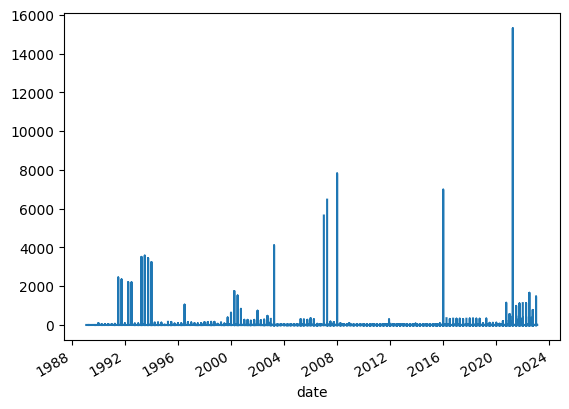

In [26]:
df_ratios['quickRatio'].plot()

In [27]:
df_ratios.isnull().sum()

symbol                                    0
currentRatio                           3195
quickRatio                             3195
cashRatio                              3195
daysOfSalesOutstanding                  396
daysOfInventoryOutstanding             7412
operatingCycle                         7421
daysOfPayablesOutstanding              7412
cashConversionCycle                    7421
grossProfitMargin                       396
operatingProfitMargin                   396
pretaxProfitMargin                      396
netProfitMargin                         396
effectiveTaxRate                       1311
returnOnAssets                           30
returnOnEquity                          241
returnOnCapitalEmployed                3198
netIncomePerEBT                        1311
ebtPerEbit                             5728
ebitPerRevenue                          396
debtRatio                                30
debtEquityRatio                         241
longTermDebtToCapitalization    

## Build Key Metrics Table

In [28]:
metrics_header_list = ['symbol', 'date', 'period', 'revenuePerShare', 'netIncomePerShare', 'operatingCashFlowPerShare', 
                       'freeCashFlowPerShare', 'cashPerShare', 'bookValuePerShare', 'tangibleBookValuePerShare', 
                       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap', 'enterpriseValue', 'peRatio', 
                       'priceToSalesRatio', 'pocfratio', 'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales', 
                       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow', 'evToFreeCashFlow', 'earningsYield', 
                       'freeCashFlowYield', 'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio', 
                       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRatio', 
                       'salesGeneralAndAdministrativeToRevenue', 'researchAndDdevelopementToRevenue', 
                       'intangiblesToTotalAssets', 'capexToOperatingCashFlow', 'capexToRevenue', 'capexToDepreciation', 
                       'stockBasedCompensationToRevenue', 'grahamNumber', 'roic', 'returnOnTangibleAssets', 
                       'grahamNetNet', 'workingCapital', 'tangibleAssetValue', 'netCurrentAssetValue', 'investedCapital', 
                       'averageReceivables', 'averagePayables', 'averageInventory', 'daysSalesOutstanding', 
                       'daysPayablesOutstanding', 'daysOfInventoryOnHand', 'receivablesTurnover', 'payablesTurnover', 
                       'inventoryTurnover', 'roe', 'capexPerShare']

In [29]:
key_metrics_columns

Index(['symbol', 'date', 'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRatio',
       'salesGeneralAndAdministrativeToRevenue',
       'researchAndDdevelopementToRevenue', 'intangiblesToTotalAssets',
       'capexToOperatingCashFlow', 'capexToRevenue', 'capexToDepreciation',
       'stockBasedCompensationToRevenue', 'grahamNumber', 'roic',
       'returnOnTangibleAssets', 'grahamNetNet', 'wo

In [30]:
metrics_list=[]

for metric in key_metrics_columns:
    
    metrics_list.append(f"output['{metric}']")

metrics_list

["output['symbol']",
 "output['date']",
 "output['period']",
 "output['revenuePerShare']",
 "output['netIncomePerShare']",
 "output['operatingCashFlowPerShare']",
 "output['freeCashFlowPerShare']",
 "output['cashPerShare']",
 "output['bookValuePerShare']",
 "output['tangibleBookValuePerShare']",
 "output['shareholdersEquityPerShare']",
 "output['interestDebtPerShare']",
 "output['marketCap']",
 "output['enterpriseValue']",
 "output['peRatio']",
 "output['priceToSalesRatio']",
 "output['pocfratio']",
 "output['pfcfRatio']",
 "output['pbRatio']",
 "output['ptbRatio']",
 "output['evToSales']",
 "output['enterpriseValueOverEBITDA']",
 "output['evToOperatingCashFlow']",
 "output['evToFreeCashFlow']",
 "output['earningsYield']",
 "output['freeCashFlowYield']",
 "output['debtToEquity']",
 "output['debtToAssets']",
 "output['netDebtToEBITDA']",
 "output['currentRatio']",
 "output['interestCoverage']",
 "output['incomeQuality']",
 "output['dividendYield']",
 "output['payoutRatio']",
 "output['s

In [41]:
# Test batch slicing stock list and retrieving metrics data
#use big stocks list above

## Async I/O method - Metrics Data

def retrieve_metrics_data(stocks):
    
    nest_asyncio.apply()

    os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

    api_key='22ee76be0cd226eba06f81a9d2783cb0'
    

    async def fetch_price(session, stock, api_key):
        
        
        url = f'https://financialmodelingprep.com/api/v3/key-metrics/{stock}?period=quarter&limit=400&apikey={api_key}'
        async with session.get(url) as resp:
        
            try:
                response = await resp.json()
                periods = len([sub['date'] for sub in response]) # count number of periods captured
                return response, periods

        
            except IndexError:   # exception handling for unrecognisable ticker
                                
                
                return ''

    async def main():
            
            await asyncio.sleep(20)  # delay 20 seconds
            
            async with ClientSession() as session:
                tasks = []
            
                for stock in stocks:
                    tasks.append(loop.create_task(
                        fetch_price(session, stock, api_key)
                    ))
                res = await asyncio.gather(*tasks)  # tuple format
            
#            print(res[0][0][0]['date'])  1st period for # 1 stock
#            print(res[0][0][5]['date'])  5th period for # 1 stock

#            print(res[1][0][0]['date'])  date for # 2 stock

#            print(res[0][0][1]) ratios for second stock
            
#            print(res[0][1]) periods #1 stock
#            print(res[1][1]) periods #2 stock

          
                for i in range(0, len(stocks)):
                    for j in range(0, res[i][1]):  # res[0][1] is the # of periods. res[0][0][i] = ratios
                        output=res[i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                            # output [0][0]['date']

           
                # write results to file = async_ratios.csv
        
                        file = open('async_metrics_test.csv', 'a', newline ='')    
                    
                        with file:   
                            write = csv.writer(file)
                        
                            write.writerow([output['symbol'], output['date'], output['period'], output['revenuePerShare'],
                                            output['netIncomePerShare'], output['operatingCashFlowPerShare'], output['freeCashFlowPerShare'], 
                                            output['cashPerShare'], output['bookValuePerShare'], output['tangibleBookValuePerShare'],
                                            output['shareholdersEquityPerShare'], output['interestDebtPerShare'], output['marketCap'], output['enterpriseValue'],
                                            output['peRatio'], output['priceToSalesRatio'], output['pocfratio'], output['pfcfRatio'], output['pbRatio'],
                                            output['ptbRatio'], output['evToSales'], output['enterpriseValueOverEBITDA'],
                                            output['evToOperatingCashFlow'], output['evToFreeCashFlow'], output['earningsYield'],
                                            output['freeCashFlowYield'], output['debtToEquity'], output['debtToAssets'], output['netDebtToEBITDA'],
                                            output['currentRatio'], output['interestCoverage'], output['incomeQuality'],
                                            output['dividendYield'], output['payoutRatio'], output['salesGeneralAndAdministrativeToRevenue'],
                                            output['researchAndDdevelopementToRevenue'], output['intangiblesToTotalAssets'],
                                            output['capexToOperatingCashFlow'], output['capexToRevenue'], output['capexToDepreciation'],
                                            output['stockBasedCompensationToRevenue'], output['grahamNumber'], output['roic'],
                                            output['returnOnTangibleAssets'], output['grahamNetNet'], output['workingCapital'],
                                            output['tangibleAssetValue'], output['netCurrentAssetValue'], output['investedCapital'],
                                            output['averageReceivables'], output['averagePayables'], output['averageInventory'],
                                            output['daysSalesOutstanding'], output['daysPayablesOutstanding'], output['daysOfInventoryOnHand'],
                                            output['receivablesTurnover'], output['payablesTurnover'], output['inventoryTurnover'],
                                            output['roe'], output['capexPerShare']])
               
                
    def handleException(loop: asyncio.AbstractEventLoop, context: dict):
        print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
        loop.stop()
    
    loop = asyncio.get_event_loop()

    loop.set_exception_handler(handleException)
    loop.run_until_complete(main())

    return


## TESTING PROCESS DATA IN BATCHES
## testing with full column list

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

stock_list=list['Ticker'].to_list()

batch_size = 60

num_batches = int(len(stock_list)/batch_size)

start=0
end=batch_size


for i in range(0, num_batches):
    
    stocks=[]
        
    stocks = stock_list[start:end]
        
    retrieve_metrics_data(stocks)  # call function
    
    start=end
    end=start+batch_size
    
    if end>len(str(stock_list)):
            end=len(str(stock_list))
            

In [31]:
os.chdir("/Users/veesheenyuen/Desktop/")

df_metrics=pd.read_csv('DataScience/Project/async_metrics_test.csv', on_bad_lines='skip') 

In [32]:
df_metrics.columns = key_metrics_columns

df_metrics['date']= pd.to_datetime(df_metrics['date'])

df_metrics.set_index('date', inplace=True)

df_metrics

,symbol,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2022-07-31,A,Q3,5.765101,1.104027,1.093960,0.818792,3.614094,17.083893,0.986577,17.083893,...,530500000.0,973500000.0,70.459837,64.467266,116.688062,1.277323,1.396057,0.771287,0.064624,-0.275168
2022-04-30,A,Q2,5.374582,0.916388,0.946488,0.732441,4.036789,17.130435,0.896321,17.130435,...,489000000.0,908000000.0,69.278158,60.683646,113.042895,1.299111,1.483101,0.796158,0.053495,-0.214047
2022-01-31,A,Q1,5.561462,0.940199,0.847176,0.598007,3.847176,17.122924,-2.219269,17.122924,...,460500000.0,854500000.0,64.784946,55.955497,103.547120,1.389212,1.608421,0.869170,0.054909,-0.249169
2021-10-31,A,Q4,5.478548,1.458746,1.455446,1.250825,5.198020,17.785479,1.429043,17.785479,...,431000000.0,824000000.0,63.542169,52.815789,98.289474,1.416382,1.704036,0.915663,0.082019,-0.204620
2021-07-31,A,Q3,5.234323,0.871287,1.102310,0.920792,4.712871,16.323432,-0.204620,16.323432,...,419500000.0,804500000.0,63.669609,51.008174,100.299728,1.413547,1.764423,0.897311,0.053376,-0.181518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-06-30,WBC.AX,Q3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1990-03-31,WBC.AX,Q2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1990-01-31,WBC.AX,Q1,0.000000,0.000000,0.812276,0.678747,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.133529


In [33]:
df_metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60613 entries, 2022-07-31 to 1988-03-31
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   symbol                                  60613 non-null  object 
 1   period                                  60613 non-null  object 
 2   revenuePerShare                         60613 non-null  float64
 3   netIncomePerShare                       60613 non-null  float64
 4   operatingCashFlowPerShare               52266 non-null  float64
 5   freeCashFlowPerShare                    52266 non-null  float64
 6   cashPerShare                            50235 non-null  float64
 7   bookValuePerShare                       50235 non-null  float64
 8   tangibleBookValuePerShare               50235 non-null  float64
 9   shareholdersEquityPerShare              50235 non-null  float64
 10  interestDebtPerShare                    5

In [40]:
df_metrics.isna().sum()/len(df_metrics)

symbol                                    0.000000
period                                    0.000000
revenuePerShare                           0.000000
netIncomePerShare                         0.000000
operatingCashFlowPerShare                 0.137710
freeCashFlowPerShare                      0.137710
cashPerShare                              0.171217
bookValuePerShare                         0.171217
tangibleBookValuePerShare                 0.171217
shareholdersEquityPerShare                0.171217
interestDebtPerShare                      0.171217
marketCap                                 0.000000
enterpriseValue                           0.186049
peRatio                                   0.000000
priceToSalesRatio                         0.000000
pocfratio                                 0.000000
pfcfRatio                                 0.000000
pbRatio                                   0.000000
ptbRatio                                  0.000000
evToSales                      

In [ ]:
[lambda symbol: output['{symbol}'] for symbol in metrics_header_list]



In [147]:
## TESTING LAMBDA

#os.chdir("/Users/veesheenyuen/Desktop/")

#list=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

#stocks=list['Ticker'].to_list()

stocks=['NTR',
        '9432.T',
        'NVFVES',
        'NWG',
        'NBS.L',
        'O39.SI',
        'ODGR',
        'OPBANK',
        'ORA.PA',
        'ORANOF',
        'ORG.AX',
        'ORIEAS',
        '8591.T',
        'ORSTED',
        'PEMEX',
        'PERTIJ',
        'PBR',
        'PETMK',
        'PEUGOT',
        'TLK',
        'PHIA.AS',
        'PLNIJ',
        'PKX',
        'PPFTEL',
        'PROXBB',
        'PUK',
        'PSMP.DE',
        'PUB.PA',
        'QBE.AX',
        'RABOBK',
        '4755.T',
        'RAW.DE',
        'RKT.L',
        'RBOSGR',
        'RCI-B.TO',
        'SHEL.L',
        'RDEIY',
        'REN.AS',
        'RNO.PA',
        'REP.MC',
        'RI.PA',
        'RELIANCE.NS',
        'ROSNRM',
        'RTO.L',
        'RWE.DE',
        'RXL.PA',
        'SABIC',
        'SAB.MC',
        'SAMBA',
        'SAN.PA',
        'SANSCF',
        'SAN.MC',
        'SANB.L',
        'SANUSA',
        'SAP.DE',
        'SAPSJ',
        'SAZGR',
        'SBERRU',
        'SBIN.NS',
        'SCANIA',
        'SCBGER',
        'SCBNOR',
        'SCMN.SW',
        'SDFGR',
        'SESGFP',
        'SFD',
        'SFRFP',
        'SGOFP',
        'SGSPAA',
        'SGTOPT',
        'SHA.DE',
        'SHB-A.ST',
        '0873.HK',
        'SHIN',
        'SIBNEF',
        'SIA.BR',
        '3377.HK',
        '0338.HK',
        '0386.HK',
        '8630.T',
        '096770.KS',
        'SMIN.L',
        'GLE.PA',
        '9984.T',
        'SOLB.BR',
        'SPLLLC',
        'SSE.L',
        'STAN.L',
        'STEDIN',
        'STENA',
        'STE-R.ST',
        'STO.AX',
        'SGAPY',
        'STYRO',
        'SU',
        'SU.PA',
        '8053.T',
        '8316.T',
        'SUNAU',
        '0016.HK',
        'SWED-A.ST',
        'SW.PA',
        '0019.HK',
        'SYNNVX',
        'SZU.DE',
        '4502.T',
        'TLX.DE',
        'TECK',
        'TDCDC',
        'TEF',
        'TELIA.ST',
        'TEL.OL',
        'TV',
        'TEMASE',
        '0700.HK',
        'TIT.BR',
        'TA1.DE',
        'TKA.DE',
        'TLS.AX',
        'TNET.BR',
        'TTE',
        'TM',
        '8015.T',
        'TRI',
        'TSCO.L',
        'TTE.PA',
        'TTMTIN',
        'TVOYFH',
        'UBIIM',
        'UCG.MI',
        'URW.AS',
        'ULVR.L',
        'MUFG',
        'UNI.MI',
        'UNILAB',
        'UPCB',
        'UPM.HE',
        'UU.L',
        'VALE',
        'VATFAL',
        'OEWA.DE',
        'VIE.PA',
        'VIV.PA',
        'VOLV-B.ST',
        'VMUKLN',
        '2202.HK',
        'VOVCAB',
        'VOW3.DE',
        'WESAU',
        'WBRBY',
        'WKL.AS',
        'WOORIB',
        'WPLAU',
        'WBC.AX',
        'ZIGGO']
        
#use big stocks list above

## Async I/O method - Metrics Data

import nest_asyncio
from aiohttp import ClientSession
import aiofiles

nest_asyncio.apply()

os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

api_key='22ee76be0cd226eba06f81a9d2783cb0'

async def fetch_price(session, stock, api_key):
    url = f'https://financialmodelingprep.com/api/v3/key-metrics/{stock}?period=quarter&limit=400&apikey={api_key}'
    async with session.get(url) as resp:
        
        try:
            response = await resp.json()
            periods = len([sub['date'] for sub in response]) # count number of periods captured
            return response, periods
        
        except IndexError:   # exception handling for unrecognisable ticker
            return ''

async def main():
            
        async with ClientSession() as session:
            tasks = []
            
            for stock in stocks:
                tasks.append(loop.create_task(
                    fetch_price(session, stock, api_key)
                ))
            res = await asyncio.gather(*tasks)  # tuple format
            
#            print(res[0][0][0]['date'])  1st period for # 1 stock
#            print(res[0][0][5]['date'])  5th period for # 1 stock

#            print(res[1][0][0]['date'])  date for # 2 stock

#            print(res[0][0][1]) ratios for second stock
            
#            print(res[0][1]) periods #1 stock
#            print(res[1][1]) periods #2 stock

          
            for i in range(0, len(stocks)):
                for j in range(0, res[i][1]):  # res[0][1] is the # of periods. res[0][0][i] = ratios
                    output=res[i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                    # output [0][0]['date']

           
            # write results to file = async_ratios.csv
        
                    file = open('async_lambda_test.csv', 'a', newline ='')    
                    
                    with file:
                        
                        write = csv.writer(file)
                        write.writerow(lambda symbol: output[{symbol}] for symbol in metrics_header_list)
               
                
def handleException(loop: asyncio.AbstractEventLoop, context: dict):
    print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
    loop.stop()
    
loop = asyncio.get_event_loop()

loop.set_exception_handler(handleException)
loop.run_until_complete(main())



## Build Cashflow Table

In [34]:
cashflow_list=[]

for metric in cashflow_columns:
    
    cashflow_list.append(f"output['{metric}']")

cashflow_list


["output['date']",
 "output['symbol']",
 "output['reportedCurrency']",
 "output['cik']",
 "output['fillingDate']",
 "output['acceptedDate']",
 "output['calendarYear']",
 "output['period']",
 "output['netIncome']",
 "output['depreciationAndAmortization']",
 "output['deferredIncomeTax']",
 "output['stockBasedCompensation']",
 "output['changeInWorkingCapital']",
 "output['accountsReceivables']",
 "output['inventory']",
 "output['accountsPayables']",
 "output['otherWorkingCapital']",
 "output['otherNonCashItems']",
 "output['netCashProvidedByOperatingActivities']",
 "output['investmentsInPropertyPlantAndEquipment']",
 "output['acquisitionsNet']",
 "output['purchasesOfInvestments']",
 "output['salesMaturitiesOfInvestments']",
 "output['otherInvestingActivites']",
 "output['netCashUsedForInvestingActivites']",
 "output['debtRepayment']",
 "output['commonStockIssued']",
 "output['commonStockRepurchased']",
 "output['dividendsPaid']",
 "output['otherFinancingActivites']",
 "output['netCashUsed

In [42]:
# Test batch slicing stock list and retrieving CF data
#use big stocks list above

## Async I/O method - Cashflow Data

def retrieve_CF_data(stocks):

    nest_asyncio.apply()

    os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

    api_key='22ee76be0cd226eba06f81a9d2783cb0'

    async def fetch_price(session, stock, api_key):
        url = f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{stock}?period=quarter&limit=400&apikey={api_key}'
        async with session.get(url) as resp:
        
            try:
                response = await resp.json()
                periods = len([sub['date'] for sub in response]) # count number of periods captured
                return response, periods
        
            except IndexError:   # exception handling for unrecognisable ticker
                return ''

    async def main():
            
            await asyncio.sleep(20)  # delay 20 seconds
            
            async with ClientSession() as session:
                tasks = []
            
                for stock in stocks:
                    tasks.append(loop.create_task(
                        fetch_price(session, stock, api_key)
                    ))
                res = await asyncio.gather(*tasks)  # tuple format
            
#            print(res[0][0][0]['date'])  1st period for # 1 stock
#            print(res[0][0][5]['date'])  5th period for # 1 stock

#            print(res[1][0][0]['date'])  date for # 2 stock

#            print(res[0][0][1]) ratios for second stock
            
#            print(res[0][1]) periods #1 stock
#            print(res[1][1]) periods #2 stock

          
                for i in range(0, len(stocks)):
                    for j in range(0, res[i][1]):  # res[0][1] is the # of periods. res[0][0][i] = ratios
                        output=res[i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                            # output [0][0]['date']

           
                # write results to file = async_ratios.csv
        
                        file = open('async_CF.csv', 'a', newline ='')    
                    
                        with file:   
                            write = csv.writer(file)
                        
                            write.writerow([output['date'], output['symbol'], output['reportedCurrency'], output['cik'],
                                            output['calendarYear'], output['period'], output['netIncome'], output['depreciationAndAmortization'],
                                            output['deferredIncomeTax'], output['stockBasedCompensation'], output['changeInWorkingCapital'],
                                            output['accountsReceivables'], output['inventory'], output['accountsPayables'], output['otherWorkingCapital'],
                                            output['otherNonCashItems'], output['netCashProvidedByOperatingActivities'], output['investmentsInPropertyPlantAndEquipment'],
                                            output['acquisitionsNet'], output['purchasesOfInvestments'], output['salesMaturitiesOfInvestments'], 
                                            output['otherInvestingActivites'], output['netCashUsedForInvestingActivites'], output['debtRepayment'],
                                            output['commonStockIssued'], output['commonStockRepurchased'], output['dividendsPaid'],
                                            output['otherFinancingActivites'], output['netCashUsedProvidedByFinancingActivities'],
                                            output['effectOfForexChangesOnCash'], output['netChangeInCash'], output['cashAtEndOfPeriod'],
                                            output['cashAtBeginningOfPeriod'], output['operatingCashFlow'], output['capitalExpenditure'],
                                            output['freeCashFlow']])
               
                
    def handleException(loop: asyncio.AbstractEventLoop, context: dict):
        print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
        loop.stop()
    
    loop = asyncio.get_event_loop()

    loop.set_exception_handler(handleException)
    loop.run_until_complete(main())

    return


## TESTING PROCESS DATA IN BATCHES
## testing with full column list

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

stock_list=list['Ticker'].to_list()

batch_size = 60

num_batches = int(len(stock_list)/batch_size)

start=0
end=batch_size


for i in range(0, num_batches):
    
    stocks=[]
        
    stocks = stock_list[start:end]
        
    retrieve_CF_data(stocks)  # call function
    
    start=end
    end=start+batch_size
    
    if end>len(str(stock_list)):
            end=len(str(stock_list))
            

In [35]:
os.chdir("/Users/veesheenyuen/Desktop/")

df_CF=pd.read_csv('DataScience/Project/async_CF.csv', on_bad_lines='skip') 

In [36]:
cashflow_columns=cashflow_columns.drop(labels=['fillingDate', 'acceptedDate', 'link', 'finalLink'])

In [37]:
df_CF.columns = cashflow_columns

df_CF['date']= pd.to_datetime(df_CF['date'])

df_CF.set_index('date', inplace=True)

df_CF

,symbol,reportedCurrency,cik,calendarYear,period,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,...,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,A,USD,1090872.0,2022,Q4,368000000.0,73000000.0,-17000000.0,26000000.0,-2.000000e+06,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,448000000.0,-7.000000e+07,3.780000e+08
2022-07-31,A,USD,1090872.0,2022,Q3,329000000.0,80000000.0,6000000.0,28000000.0,-1.310000e+08,...,-62000000.0,992000000.0,-362000000.0,-6000000.0,-115000000.0,1.073000e+09,1.188000e+09,326000000.0,-8.200000e+07,2.440000e+08
2022-04-30,A,USD,1090872.0,2022,Q2,274000000.0,82000000.0,-5000000.0,27000000.0,-9.500000e+07,...,-63000000.0,174000000.0,-123000000.0,-12000000.0,72000000.0,1.188000e+09,1.116000e+09,283000000.0,-6.400000e+07,2.190000e+08
2022-01-31,A,USD,1090872.0,2022,Q1,283000000.0,82000000.0,24000000.0,44000000.0,-2.330000e+08,...,-63000000.0,204000000.0,-546000000.0,-4000000.0,-374000000.0,1.116000e+09,1.490000e+09,255000000.0,-7.500000e+07,1.800000e+08
2021-10-31,A,USD,1090872.0,2021,Q4,442000000.0,84000000.0,-27000000.0,22000000.0,1.000000e+07,...,-59000000.0,156000000.0,-324000000.0,-3000000.0,55000000.0,1.490000e+09,1.435000e+09,441000000.0,-6.200000e+07,3.790000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-01-31,WBC.AX,AUD,NaN,1991,Q1,119176326.5,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,-4.402573e+07,119176326.5,0.000000e+00,1.191763e+08
1990-09-30,WBC.AX,AUD,NaN,1990,Q4,171231579.0,48049059.5,0.0,0.0,1.460558e+08,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08
1990-06-30,WBC.AX,AUD,NaN,1990,Q3,171231579.0,48049059.5,0.0,0.0,1.460558e+08,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08


In [38]:
df_CF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44600 entries, 2022-10-31 to 1990-01-31
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   symbol                                    44600 non-null  object 
 1   reportedCurrency                          44600 non-null  object 
 2   cik                                       33066 non-null  float64
 3   calendarYear                              44600 non-null  int64  
 4   period                                    44600 non-null  object 
 5   netIncome                                 44600 non-null  float64
 6   depreciationAndAmortization               44600 non-null  float64
 7   deferredIncomeTax                         44600 non-null  float64
 8   stockBasedCompensation                    44600 non-null  float64
 9   changeInWorkingCapital                    44600 non-null  float64
 10  accountsReceivabl

In [42]:
preimpute_CF=df_CF.select_dtypes(include = ['float']).to_numpy() 

In [45]:
preimpute_CF

array([[ 1.09087200e+06,  3.68000000e+08,  7.30000000e+07, ...,
         4.48000000e+08, -7.00000000e+07,  3.78000000e+08],
       [ 1.09087200e+06,  3.29000000e+08,  8.00000000e+07, ...,
         3.26000000e+08, -8.20000000e+07,  2.44000000e+08],
       [ 1.09087200e+06,  2.74000000e+08,  8.20000000e+07, ...,
         2.83000000e+08, -6.40000000e+07,  2.19000000e+08],
       ...,
       [            nan,  1.71231579e+08,  4.80490595e+07, ...,
         8.64519522e+08, -1.42117363e+08,  7.22402159e+08],
       [            nan,  1.71231579e+08,  4.80490595e+07, ...,
         8.64519522e+08, -1.42117363e+08,  7.22402159e+08],
       [            nan,  1.71231579e+08,  4.80490595e+07, ...,
         8.64519522e+08, -1.42117363e+08,  7.22402159e+08]])

## SAIT Imputation

In [12]:
saits = SAITS(n_steps=48, n_features=33, n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, dropout=0.1, epochs=10)

No given device, using default device: cpu
Model initialized successfully. Number of the trainable parameters: 1371446


In [44]:
saits.fit(preimpute_CF)

AssertionError: input should have 3 dimensions [n_samples, seq_len, n_features],but got shape=torch.Size([44600, 31])

In [13]:
from pypots.data import load_specific_dataset, mcar, masked_fill

data = load_specific_dataset('physionet_2012')

Loading the dataset physionet_2012 with TSDB (https://github.com/WenjieDu/Time_Series_Database)...
Starting preprocessing physionet_2012...
Dataset physionet_2012 has already been downloaded. Processing directly...
Dataset physionet_2012 has already been cached. Loading from cache directly...
Loaded successfully!


In [14]:
data['y']

,In-hospital_death
RecordID,
132592,0
140662,0
140104,0
134685,0
134849,0
...,...
158752,0
157307,0
158034,0


In [15]:
data['X']

,RecordID,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,...,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH
0,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,35.35,NaN,NaN,480.0,NaN,-1.0,NaN
1,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
2,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,NaN,NaN,NaN,170.0,NaN,NaN,NaN
3,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,37.80,NaN,NaN,60.0,NaN,NaN,NaN
4,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575419,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,...,NaN,NaN,122.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN
575420,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
575421,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,147.0,37.30,NaN,NaN,50.0,NaN,NaN,NaN
575422,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,...,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Wavelet denoising

In [16]:
from scipy import signal

In [17]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

y = denoise_wavelet(df_ratios['quickRatio'], wavelet='db1', mode='soft', method='VisuShrink', rescale_sigma='True')

pd.DataFrame(y).plot()

NameError: name 'df_ratios' is not defined

In [15]:
y

array([1.56077074, 1.56077074, 1.56077074, 1.56077074, 1.56077074,
       1.56077074, 1.56077074, 1.56077074, 1.43139877, 1.22347215,
       1.30451264, 1.30451264, 1.78536851, 2.43249487, 2.30056249,
       2.30056249, 2.71863015, 2.71863015, 2.71863015, 2.71863015,
       2.71863015, 2.71863015, 2.70093592, 2.73632439, 2.66858293,
       2.66858293, 2.66858293, 2.66858293, 2.82760811, 2.82760811,
       2.80541122, 2.61408205, 2.1882202 , 2.1882202 , 2.1882202 ,
       2.1882202 , 2.0190213 , 2.0190213 , 2.0190213 , 2.0190213 ,
       1.61003886, 2.45685163, 2.26276255, 2.26276255, 2.38031213,
       2.38031213, 2.38863092, 1.44316041, 1.31590959, 1.31590959,
       1.31162709, 2.43992805, 1.65615914, 1.65615914, 1.65615914,
       1.65615914, 1.14541934, 1.14541934, 1.08138958, 1.37052575,
       1.73834071, 1.73834071, 1.79707121, 1.79707121, 1.857428  ,
       1.857428  , 1.95484185, 1.76001415, 1.857428  , 1.857428  ,
       1.857428  , 1.857428  , 1.52752891, 1.52752891, 1.52752

## Extract B/S Data Using FMP API 

In [14]:
stocks=['A', 'ABT']


## Async I/O method - BS Data

import nest_asyncio
from aiohttp import ClientSession
import aiofiles

nest_asyncio.apply()

os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

api_key='22ee76be0cd226eba06f81a9d2783cb0'

async def fetch_price(session, stock, api_key):
    url = f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{stock}?period=quarter&limit=400&apikey={api_key}'
    async with session.get(url) as resp:
        
        try:
            response = await resp.json()
            periods = len([sub['date'] for sub in response]) # count number of periods captured
            return response, periods
        
        except IndexError:   # exception handling for unrecognisable ticker
            return ''

async def main():
            
        async with ClientSession() as session:
            tasks = []
            
            for stock in stocks:
                tasks.append(loop.create_task(
                    fetch_price(session, stock, api_key)
                ))
            res = await asyncio.gather(*tasks)  # tuple format
            
#            print(res[0][0][0]['date'])  1st period for # 1 stock
#            print(res[0][0][5]['date'])  5th period for # 1 stock

#            print(res[1][0][0]['date'])  date for # 2 stock

#            print(res[0][0][1]) ratios for second stock
            
#            print(res[0][1]) periods #1 stock
#            print(res[1][1]) periods #2 stock

          
            for i in range(0,len(stocks)):
                for j in range(0, res[i][1]):  # res[0][1] is the # of periods. res[0][0][i] = ratios
                
                    output=res[i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                    # output [0][0]['date']

           
            # write results to file = async_test.csv
        
                    file = open('async_bs.csv', 'a', newline ='')
                                
                    with file:   
                        write = csv.writer(file)
                        write.writerow([output['date'], output['symbol'], output['inventory'], output['cashAndCashEquivalents']])
               
                
def handleException(loop: asyncio.AbstractEventLoop, context: dict):
    print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
    loop.stop()
    
loop = asyncio.get_event_loop()

loop.set_exception_handler(handleException)
loop.run_until_complete(main())



In [2]:
os.chdir("/Users/veesheenyuen/Desktop/")

df_bs=pd.read_csv('DataScience/Project/async_bs.csv')  

df_bs.columns =['date','symbol','inventory','cashAndCashEquivalents']

df_bs['date']= pd.to_datetime(df_bs['date'])

df_bs.set_index('date', inplace=True)

df_bs


,symbol,inventory,cashAndCashEquivalents
date,,,
2022-07-31,A,1010000000,1071000000
2022-04-30,A,937000000,1186000000
2022-01-31,A,879000000,1113000000
2021-10-31,A,830000000,1484000000
2021-07-31,A,818000000,1428000000
...,...,...,...
1989-12-31,ABT,696000000,13600000
1988-12-31,ABT,611300000,582600000
1987-12-31,ABT,612200000,519900000


In [9]:
balance_sheet_columns

Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'cashAndCashEquivalents',
       'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
       'inventory', 'otherCurrentAssets', 'totalCurrentAssets',
       'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
       'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
       'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
       'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
       'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
       'longTermDebt', 'deferredRevenueNonCurrent',
       'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
       'totalNonCurrentLiabilities', 'otherLiabilities',
       'capitalLeaseObligations', 'totalLiabilities', 'preferredStock',
       'commonStock', 'retainedEarnings',
       'accumulatedOtherComprehensiveIncomeLoss',
 

In [12]:
# Test batch slicing stock list and retrieving BS data
#use big stocks list above

## Async I/O method - B/S Data

def retrieve_BS_data(stocks):

    nest_asyncio.apply()

    os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

    api_key='22ee76be0cd226eba06f81a9d2783cb0'

    async def fetch_price(session, stock, api_key):
        url = f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{stock}?period=quarter&limit=400&apikey={api_key}'
        async with session.get(url) as resp:
        
            try:
                response = await resp.json()
                periods = len([sub['date'] for sub in response]) # count number of periods captured
                return response, periods
        
            except IndexError:   # exception handling for unrecognisable ticker
                return ''

    async def main():
            
            await asyncio.sleep(20)  # delay 20 seconds
            
            async with ClientSession() as session:
                tasks = []
            
                for stock in stocks:
                    tasks.append(loop.create_task(
                        fetch_price(session, stock, api_key)
                    ))
                res = await asyncio.gather(*tasks)  # tuple format
            
#            print(res[0][0][0]['date'])  1st period for # 1 stock
#            print(res[0][0][5]['date'])  5th period for # 1 stock

#            print(res[1][0][0]['date'])  date for # 2 stock

#            print(res[0][0][1]) ratios for second stock
            
#            print(res[0][1]) periods #1 stock
#            print(res[1][1]) periods #2 stock

          
                for i in range(0, len(stocks)):
                    for j in range(0, res[i][1]):  # res[0][1] is the # of periods. res[0][0][i] = ratios
                        output=res[i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                            # output [0][0]['date']

           
                # write results to file = async_ratios.csv
        
                        file = open('async_BS.csv', 'a', newline ='')    
                    
                        with file:   
                            write = csv.writer(file)
                        
                            write.writerow([output['date'], output['symbol'], output['reportedCurrency'], output['cik'], output['acceptedDate'], 
                                             output['calendarYear'], output['period'], output['cashAndCashEquivalents'],
                                             output['shortTermInvestments'], output['cashAndShortTermInvestments'], output['netReceivables'],
                                             output['inventory'], output['otherCurrentAssets'], output['totalCurrentAssets'],
                                             output['propertyPlantEquipmentNet'], output['goodwill'], output['intangibleAssets'],
                                             output['goodwillAndIntangibleAssets'], output['longTermInvestments'], output['taxAssets'],
                                             output['otherNonCurrentAssets'], output['totalNonCurrentAssets'], output['otherAssets'],
                                             output['totalAssets'], output['accountPayables'], output['shortTermDebt'], output['taxPayables'],
                                             output['deferredRevenue'], output['otherCurrentLiabilities'], output['totalCurrentLiabilities'],
                                             output['longTermDebt'], output['deferredRevenueNonCurrent'],
                                             output['deferredTaxLiabilitiesNonCurrent'], output['otherNonCurrentLiabilities'],
                                             output['totalNonCurrentLiabilities'], output['otherLiabilities'],
                                             output['capitalLeaseObligations'], output['totalLiabilities'], output['preferredStock'],
                                             output['commonStock'], output['retainedEarnings'],
                                             output['accumulatedOtherComprehensiveIncomeLoss'],
                                             output['othertotalStockholdersEquity'], output['totalStockholdersEquity'],
                                             output['totalEquity'], output['totalLiabilitiesAndStockholdersEquity'],
                                             output['minorityInterest'], output['totalLiabilitiesAndTotalEquity'],
                                             output['totalInvestments'], output['totalDebt'], output['netDebt']])
               
                
    def handleException(loop: asyncio.AbstractEventLoop, context: dict):
        print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
        loop.stop()
    
    loop = asyncio.get_event_loop()

    loop.set_exception_handler(handleException)
    loop.run_until_complete(main())

    return


## TESTING PROCESS DATA IN BATCHES
## testing with full column list

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

stock_list=list['Ticker'].to_list()

batch_size = 60

num_batches = int(len(stock_list)/batch_size)

start=0
end=batch_size


for i in range(0, num_batches):
    
    stocks=[]
        
    stocks = stock_list[start:end]
        
    retrieve_BS_data(stocks)  # call function
    
    start=end
    end=start+batch_size
    
    if end>len(str(stock_list)):
            end=len(str(stock_list))
            

## Extract Income Statement Data Using FMP API

In [15]:
income_statement_columns

Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome',
       'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut',
       'weightedAverageShsOutDil', 'link', 'finalLink'],
      dtype='object')

In [17]:
# Test batch slicing stock list and retrieving IS data
#use big stocks list above

## Async I/O method - IS Data

def retrieve_IS_data(stocks):

    nest_asyncio.apply()

    os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

    api_key='22ee76be0cd226eba06f81a9d2783cb0'

    async def fetch_price(session, stock, api_key):
        url = f'https://financialmodelingprep.com/api/v3/income-statement/{stock}?period=quarter&limit=400&apikey={api_key}'
        async with session.get(url) as resp:
        
            try:
                response = await resp.json()
                periods = len([sub['date'] for sub in response]) # count number of periods captured
                return response, periods
        
            except IndexError:   # exception handling for unrecognisable ticker
                return ''

    async def main():
            
            await asyncio.sleep(20)  # delay 20 seconds
            
            async with ClientSession() as session:
                tasks = []
            
                for stock in stocks:
                    tasks.append(loop.create_task(
                        fetch_price(session, stock, api_key)
                    ))
                res = await asyncio.gather(*tasks)  # tuple format
            
#            print(res[0][0][0]['date'])  1st period for # 1 stock
#            print(res[0][0][5]['date'])  5th period for # 1 stock

#            print(res[1][0][0]['date'])  date for # 2 stock

#            print(res[0][0][1]) ratios for second stock
            
#            print(res[0][1]) periods #1 stock
#            print(res[1][1]) periods #2 stock

          
                for i in range(0, len(stocks)):
                    for j in range(0, res[i][1]):  # res[0][1] is the # of periods. res[0][0][i] = ratios
                        output=res[i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                            # output [0][0]['date']

           
                # write results to file = async_ratios.csv
        
                        file = open('async_IS.csv', 'a', newline ='')    
                    
                        with file:   
                            write = csv.writer(file)
                        
                            write.writerow([output['date'], output['symbol'], output['reportedCurrency'], output['cik'], 
                                            output['calendarYear'], output['period'], output['revenue'], output['costOfRevenue'],
                                            output['grossProfit'], output['grossProfitRatio'], output['researchAndDevelopmentExpenses'],
                                            output['generalAndAdministrativeExpenses'], output['sellingAndMarketingExpenses'],
                                            output['sellingGeneralAndAdministrativeExpenses'], output['otherExpenses'],
                                            output['operatingExpenses'], output['costAndExpenses'], output['interestIncome'],
                                            output['interestExpense'], output['depreciationAndAmortization'], output['ebitda'],
                                            output['ebitdaratio'], output['operatingIncome'], output['operatingIncomeRatio'],
                                            output['totalOtherIncomeExpensesNet'], output['incomeBeforeTax'],
                                            output['incomeBeforeTaxRatio'], output['incomeTaxExpense'], output['netIncome'],
                                            output['netIncomeRatio'], output['eps'], output['epsdiluted'], output['weightedAverageShsOut'],
                                            output['weightedAverageShsOutDil'], output['link'], output['finalLink']])
               
                
    def handleException(loop: asyncio.AbstractEventLoop, context: dict):
        print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
        loop.stop()
    
    loop = asyncio.get_event_loop()

    loop.set_exception_handler(handleException)
    loop.run_until_complete(main())

    return


## TESTING PROCESS DATA IN BATCHES
## testing with full column list

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

stock_list=list['Ticker'].to_list()

batch_size = 60

num_batches = int(len(stock_list)/batch_size)

start=0
end=batch_size


for i in range(0, num_batches):
    
    stocks=[]
        
    stocks = stock_list[start:end]
        
    retrieve_IS_data(stocks)  # call function
    
    start=end
    end=start+batch_size
    
    if end>len(str(stock_list)):
            end=len(str(stock_list))
            

## Extract Final Ratios Data Using FMP API

In [19]:
# Test batch slicing stock list and retrieving IS data
#use big stocks list above

## Async I/O method - Ratios Data

def retrieve_ratios_data(stocks):

    nest_asyncio.apply()

    os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

    api_key='22ee76be0cd226eba06f81a9d2783cb0'

    async def fetch_price(session, stock, api_key):
        url = f'https://financialmodelingprep.com/api/v3/ratios/{stock}?period=quarter&limit=400&apikey={api_key}'
        async with session.get(url) as resp:
        
            try:
                response = await resp.json()
                periods = len([sub['date'] for sub in response]) # count number of periods captured
                return response, periods
        
            except IndexError:   # exception handling for unrecognisable ticker
                return ''

    async def main():
            
            await asyncio.sleep(20)  # delay 20 seconds
            
            async with ClientSession() as session:
                tasks = []
            
                for stock in stocks:
                    tasks.append(loop.create_task(
                        fetch_price(session, stock, api_key)
                    ))
                res = await asyncio.gather(*tasks)  # tuple format
            
#            print(res[0][0][0]['date'])  1st period for # 1 stock
#            print(res[0][0][5]['date'])  5th period for # 1 stock

#            print(res[1][0][0]['date'])  date for # 2 stock

#            print(res[0][0][1]) ratios for second stock
            
#            print(res[0][1]) periods #1 stock
#            print(res[1][1]) periods #2 stock

          
                for i in range(0, len(stocks)):
                    for j in range(0, res[i][1]):  # res[0][1] is the # of periods. res[0][0][i] = ratios
                        output=res[i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                            # output [0][0]['date']

           
                # write results to file = async_ratios.csv
        
                        file = open('async_ratios.csv', 'a', newline ='')    
                    
                        with file:   
                            write = csv.writer(file)
                        
                            write.writerow([output['date'], output['symbol'], output['currentRatio'], output['quickRatio'], 
                                            output['cashRatio'], output['daysOfSalesOutstanding'], output['daysOfInventoryOutstanding'], output['operatingCycle'],
                                            output['daysOfPayablesOutstanding'], output['cashConversionCycle'], output['grossProfitMargin'], 
                                            output['operatingProfitMargin'], output['pretaxProfitMargin'], output['netProfitMargin'], output['effectiveTaxRate'], output['returnOnAssets'], output['returnOnEquity'], 
                                            output['returnOnCapitalEmployed'], output['netIncomePerEBT'], output['ebtPerEbit'], output['ebitPerRevenue'], output['debtRatio'], output['debtEquityRatio'], output['longTermDebtToCapitalization'], 
                                            output['totalDebtToCapitalization'], output['interestCoverage'], output['cashFlowToDebtRatio'], output['companyEquityMultiplier'], output['receivablesTurnover'], output['payablesTurnover'], output['inventoryTurnover'], 
                                            output['fixedAssetTurnover'], output['assetTurnover'], output['operatingCashFlowPerShare'], output['freeCashFlowPerShare'], output['cashPerShare'], output['payoutRatio'], output['operatingCashFlowSalesRatio'], 
                                            output['freeCashFlowOperatingCashFlowRatio'], output['cashFlowCoverageRatios'], output['shortTermCoverageRatios'], output['capitalExpenditureCoverageRatio'], 
                                            output['dividendPaidAndCapexCoverageRatio'], output['dividendPayoutRatio'], output['priceBookValueRatio'], output['priceToBookRatio'], output['priceToSalesRatio'], output['priceEarningsRatio'], 
                                            output['priceToFreeCashFlowsRatio'], output['priceToOperatingCashFlowsRatio'], output['priceCashFlowRatio'], 
                                            output['priceEarningsToGrowthRatio'], output['priceSalesRatio'], output['dividendYield'], output['enterpriseValueMultiple'], output['priceFairValue']])
               
                
    def handleException(loop: asyncio.AbstractEventLoop, context: dict):
        print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
        loop.stop()
    
    loop = asyncio.get_event_loop()

    loop.set_exception_handler(handleException)
    loop.run_until_complete(main())

    return


## TESTING PROCESS DATA IN BATCHES
## testing with full column list

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/concatenated_list_latest.csv')

stock_list=list['Ticker'].to_list()

batch_size = 60

num_batches = int(len(stock_list)/batch_size)

start=0
end=batch_size


for i in range(0, num_batches):
    
    stocks=[]
        
    stocks = stock_list[start:end]
        
    retrieve_ratios_data(stocks)  # call function
    
    start=end
    end=start+batch_size
    
    if end>len(str(stock_list)):
            end=len(str(stock_list))
            

## Extract Historical Price Data Using FMP API

In [24]:
# Test batch slicing stock list and retrieving IS data
#use big stocks list above

## Async I/O method - Daily Stock Price Data

def retrieve_price_data(stocks):

    nest_asyncio.apply()

    os.chdir("/Users/veesheenyuen/Desktop/DataScience/Project")

    api_key='22ee76be0cd226eba06f81a9d2783cb0'

    async def fetch_price(session, stock, api_key):
        
        url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{stock}?serietype=line&apikey={api_key}'
        async with session.get(url) as resp:
        
            try:
                response = await resp.json()
                return response
        
            except IndexError:   # exception handling for unrecognisable ticker
                return ''
                        
            
    async def main():
            
            await asyncio.sleep(20)  # delay 20 seconds
            
            async with ClientSession() as session:
                tasks = []
            
                for stock in stocks:
                    tasks.append(loop.create_task(
                        fetch_price(session, stock, api_key)
                    ))
                res = await asyncio.gather(*tasks)  # tuple format
                        
                    
#                    print(res[i]['symbol'])  ## symbol
#                    print(len(res[i]['historical'])) # no of date periods
#                    print(res[i]['historical'][0]['date'])  ## date of first closing price in time series
#                    print(res[i]['historical'][0]['close'])  ## first closing price in time series
          
                for i in range(0, len(stocks)):
            
                    try:
                        print([res[i]['symbol'], len(res[i]['historical'])])
                    
#                        if (len(res[i]['historical'])<3560):
                        days=len(res[i]['historical'])
                                   
#                        else:
                        
#                            days=3560
                            
                    
                    
                        for j in range(0, days):  # Choose latest 704 days
#                        output=res['historical'][i][0][j] # output[0],[1] etc. will return different stocks. output[0][0] will output one period ratios
                                            # output [0][0]['date']
                        
#                        print(res[i]['symbol'])  ## symbol
#                        print(len(res[i]['historical'])) # no of periods
#                        print(res[i]['historical'][j]['date'])  ## date of first closing price in time series
#                        print(res[i]['historical'][0]['close'])  ## first closing price in time series
               
                # write results to file = async_ratios.csv
        
                            file = open('async_closing_prices.csv', 'a', newline ='')    
                    
                            with file:   
                                write = csv.writer(file)
                        
 #                           write.writerow([output['date'], output['symbol'], output['close']])
                                write.writerow([res[i]['symbol'], res[i]['historical'][j]['date'], res[i]['historical'][j]['close']])
     
                    except KeyError:
                        return ''


    def handleException(loop: asyncio.AbstractEventLoop, context: dict):
        print('Unhandled exception in async task, will stop loop. Exception context:\n%s' % (context,))
        loop.stop()
    
    loop = asyncio.get_event_loop()

    loop.set_exception_handler(handleException)
    loop.run_until_complete(main())

    return


## TESTING PROCESS DATA IN BATCHES
## testing with full column list

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/concatenated_list_for_prices.csv')

stock_list=list['Ticker'].to_list()

batch_size = 60

num_batches = int(len(stock_list)/batch_size)

start=0
end=batch_size


for i in range(0, num_batches):
    
    stocks=[]
        
    stocks = stock_list[start:end]
        
    retrieve_price_data(stocks)  # call function
    
    start=end
    end=start+batch_size
    
    if end>len(str(stock_list)):
            end=len(str(stock_list))
            

['A', 5898]
['AAPL', 10684]
['ABBV', 2599]
['ABC', 7067]
['ABT', 10872]
['ADM', 10872]
['ADP', 12658]
['AES', 8021]
['AET', 5781]
['AFG', 10872]
['AGR', 1853]
['AIG', 12692]
['ALL', 7531]
['ALLY', 2330]
['AMAT', 10872]
['AMGN', 10049]
['AMP', 4435]
['AMT', 4240]
['AMZN', 6532]
['AN', 8305]
['ANTM', 5216]
['APD', 10872]
['ARW', 10872]
['ASML', 7081]
['AVB', 7335]
['AVT', 12608]
['AVY', 12658]
['AXP', 12838]
['AZN', 7546]
['AZO', 8081]
['BA', 15437]
['BABA', 2167]
['BAC', 12658]
['BAX', 10464]
['BBY', 9585]
['BDX', 12658]
['BIDU', 4463]
['BK', 11650]
['BLL', 12426]
['BMO', 7176]
['BMY', 12838]
['BNS', 5946]
['BSX', 7794]
['BWA', 7481]
['C', 9752]
['CAG', 10872]
['CAH', 10016]
['CAR', 9988]
['CAT', 15437]
['CB', 8518]
['CCB', 1204]
['CCI', 6215]
['CI', 10357]
['CL', 12609]
['CLX', 12658]
['CM', 6405]
['CMCSA', 10872]
['CMI', 12658]
['CNA', 12658]
['CNHI', 2412]
['CNP', 15437]
['COF', 7162]
['COP', 10419]
['COST', 9277]
['CPB', 12658]
['CPT', 7497]
['CS', 7038]
['CSCO', 8363]
['CSTM', 2501

In [25]:
# Check output

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/async_closing_prices.csv')

list


,A,2023-04-28,135.71
0,A,2023-04-27,133.250000
1,A,2023-04-26,133.120000
2,A,2023-04-25,130.370000
3,A,2023-04-24,138.480000
4,A,2023-04-21,138.500000
...,...,...,...
2771761,RELIANCE.NS,1996-01-05,15.658285
2771762,RELIANCE.NS,1996-01-04,15.766594
2771763,RELIANCE.NS,1996-01-03,15.913584
2771764,RELIANCE.NS,1996-01-02,15.793671


# Merge two dataframes based on date index and corresponding symbol

In [26]:
df = df_ratios.merge(df_bs, on=['date', 'symbol'])


In [27]:
df

,symbol,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,grossProfitMargin,inventory,cashAndCashEquivalents
date,,,,,,,,,,,,
2022-07-31,A,1.940063,1.273396,0.563091,285.753783,116.688062,187.147899,64.467266,122.680633,0.546566,1010000000,1071000000
2022-04-30,A,2.009377,1.348042,0.654164,280.961419,113.042895,182.321054,60.683646,121.637407,0.535781,937000000,1186000000
2022-01-31,A,2.193182,1.491793,0.702652,262.738949,103.547120,168.332067,55.955497,112.376569,0.543608,879000000,1113000000
2021-10-31,A,2.224239,1.608314,0.868852,257.698795,98.289474,161.831642,52.815789,109.015853,0.542169,830000000,1484000000
2021-07-31,A,2.106729,1.479118,0.828306,258.215637,100.299728,163.969337,51.008174,112.961162,0.537201,818000000,1428000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1991-03-31,ABT,1.313691,0.580554,0.026598,249.624153,109.622132,171.173293,47.921727,123.251566,0.596698,812300000,54300000
1990-12-31,ABT,1.229924,0.551797,0.016991,228.421145,98.126753,154.449775,44.318564,110.131210,0.582948,777600000,34000000
1990-09-30,ABT,1.234976,0.524547,0.053862,248.727104,112.913200,174.243171,44.272485,129.970687,0.577183,799300000,117500000


# KMV DTF

In [17]:
# Calculate expected return after 1 year

# Import stock portfolio from excel
df = pd.read_excel("Stock_Portfolio.xlsx")

# Calculate beta for each individual stock
for i in range(len(df)):
    x = df.loc[i, "Stock"]
    ticker = yf.Ticker(x)
    stock_beta = ticker.info["beta"]
    df.at[i, "Beta"]= round(stock_beta,2)
    
    
# find the risk free rate (10 year treasury bill)
treasury_yield10 = yf.Ticker("^TNX") 
risk_free_rate_prem = round(treasury_yield10.info['regularMarketPrice']/100,2)
risk_free_rate_prem

# assume 10 percent return on the return of market ( average return of the S&P 500)
sp500_teturn = 0.10

# Caclulate the portfolio beta
portfolio_beta = round(sum(df["Beta"]* df["stock_weight"]/100),2)
portfolio_beta

# Calculate the expected return of the portfolio
portfolio_exp_return = round(risk_free_rate_prem + portfolio_beta *(sp500_teturn - risk_free_rate_prem),2)

#calulate the expected return for each individual stock using CAPM forumla
df["exp_return"]= round(risk_free_rate_prem + df["Beta"]*(sp500_teturn - risk_free_rate_prem),2)

FileNotFoundError: [Errno 2] No such file or directory: 'Stock_Portfolio.xlsx'

In [10]:
import math
from scipy.stats import norm

def kmv(enterprise_value, short_term_debt, long_term_debt, mu, sigma, period=1):
    """
    KMV Model - https://www.math.ust.hk/~maykwok/Web_ppt/KMV/KMV.pdf
    :param enterprise_value: Enterprise Value of the Firm (can market capitalisation)
    :param short_term_debt: Firm's short term debt
    :param long_term_debt: Firm's long term debt
    :param mu: Expected Return after 1 year
    :param sigma: Expected Annualized Volatility
    :param period: period in years
    :return: EDF (Expected Default Frequency or Probability of Default)
    """

    # Calculate default point
    default_point = short_term_debt + (0.5 * long_term_debt)

    # Numerator
    numer = math.log(enterprise_value / default_point) + (mu - math.pow(sigma, 2) / 2) * period

    # Denominator
    denom = sigma * period

    # Distance to Default
    distance_to_default = numer / denom
    edf = norm.cdf(-distance_to_default)

    return edf

In [11]:
enterprise_value=7.9
short_term_debt=5.0
long_term_debt=5.0
mu=0.1
sigma=0.1

kmv(enterprise_value, short_term_debt, long_term_debt, mu, sigma, period=1)

0.07083541388671619

# XGBoost Imputer

In [20]:
data = pd.DataFrame({
    'F1': [1, 2, 3, 4],
    'F2': [1, 2, 3, np.nan],
    'F3': [3, 2, 3, 4]
})

imputer = XGBImputer(with_cv=True)
imputer.fit(
    data=data,
    missing_values_variable='F2',
    features=['F1', 'F2'],
    params={'learning_rate':0.3},
    n_jobs=4, # Parallelizing Cross-validation
    n_iter=10 # Random choices among parameters grid
)
imputer.transform(data, 'F1')

TypeError: XGBImputer.fit() got an unexpected keyword argument 'data'